In [1]:
import glob
import importlib
import os
import random
import sys
from itertools import combinations

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import prettypyplot as pplt
import scipy
import seaborn as sns
from matplotlib import ticker

import extq

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import plotting
import util

In [3]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)
pplt.load_cmaps()

In [4]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"
# S4 translocation/rotation data
cv_trajs = list(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True))
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy")[:115])
# salt bridge distances for states
sb_trajs = list(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton2.npy")[:115])
sb_models = np.load(f"{DATA_DIR}/models_centroids_feat2.npy")
# displacement charges
dq_trajs = list(np.load(f"{DATA_DIR}/raw_feat/displacement_q_0-178.npy"))
dq_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/displacement_q_179-end.npy", allow_pickle=True))
dq_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/displacement_q_anton2.npy"))
# committors
lag = 500
qp_du = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[8]  # 50 ns lag time
# weights
weights = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True)[
    8
]  # 0.1 ns lag time
# correlation functions
acf = np.load(f"{DATA_DIR}/acf_qp_dq_ds.npy")

# remove trajectory 180 (missing full data)
cv_trajs = [*cv_trajs[:180], *cv_trajs[181:]]
sb_trajs = [*sb_trajs[:180], *sb_trajs[181:]]
sb_arr = np.concatenate(sb_trajs)
cv_arr = np.concatenate(cv_trajs)
qp_du = [*qp_du[:180], *qp_du[181:]]
weights = [*weights[:180], *weights[181:]]

In [5]:
print(
    cv_arr.shape,
    sb_arr.shape,
    np.concatenate(qp_du).shape,
    np.concatenate(dq_trajs).shape,
)

(4050115, 2) (4050115, 60) (4050115,) (4050115,)


In [6]:
models = np.loadtxt("/project/dinner/scguo/ci-vsd/models/MD-clustering-center/all.txt")
sb_models = np.load("/project/dinner/scguo/ci-vsd/data/models_centroids_feat2.npy")

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in divide
  return numer / denom


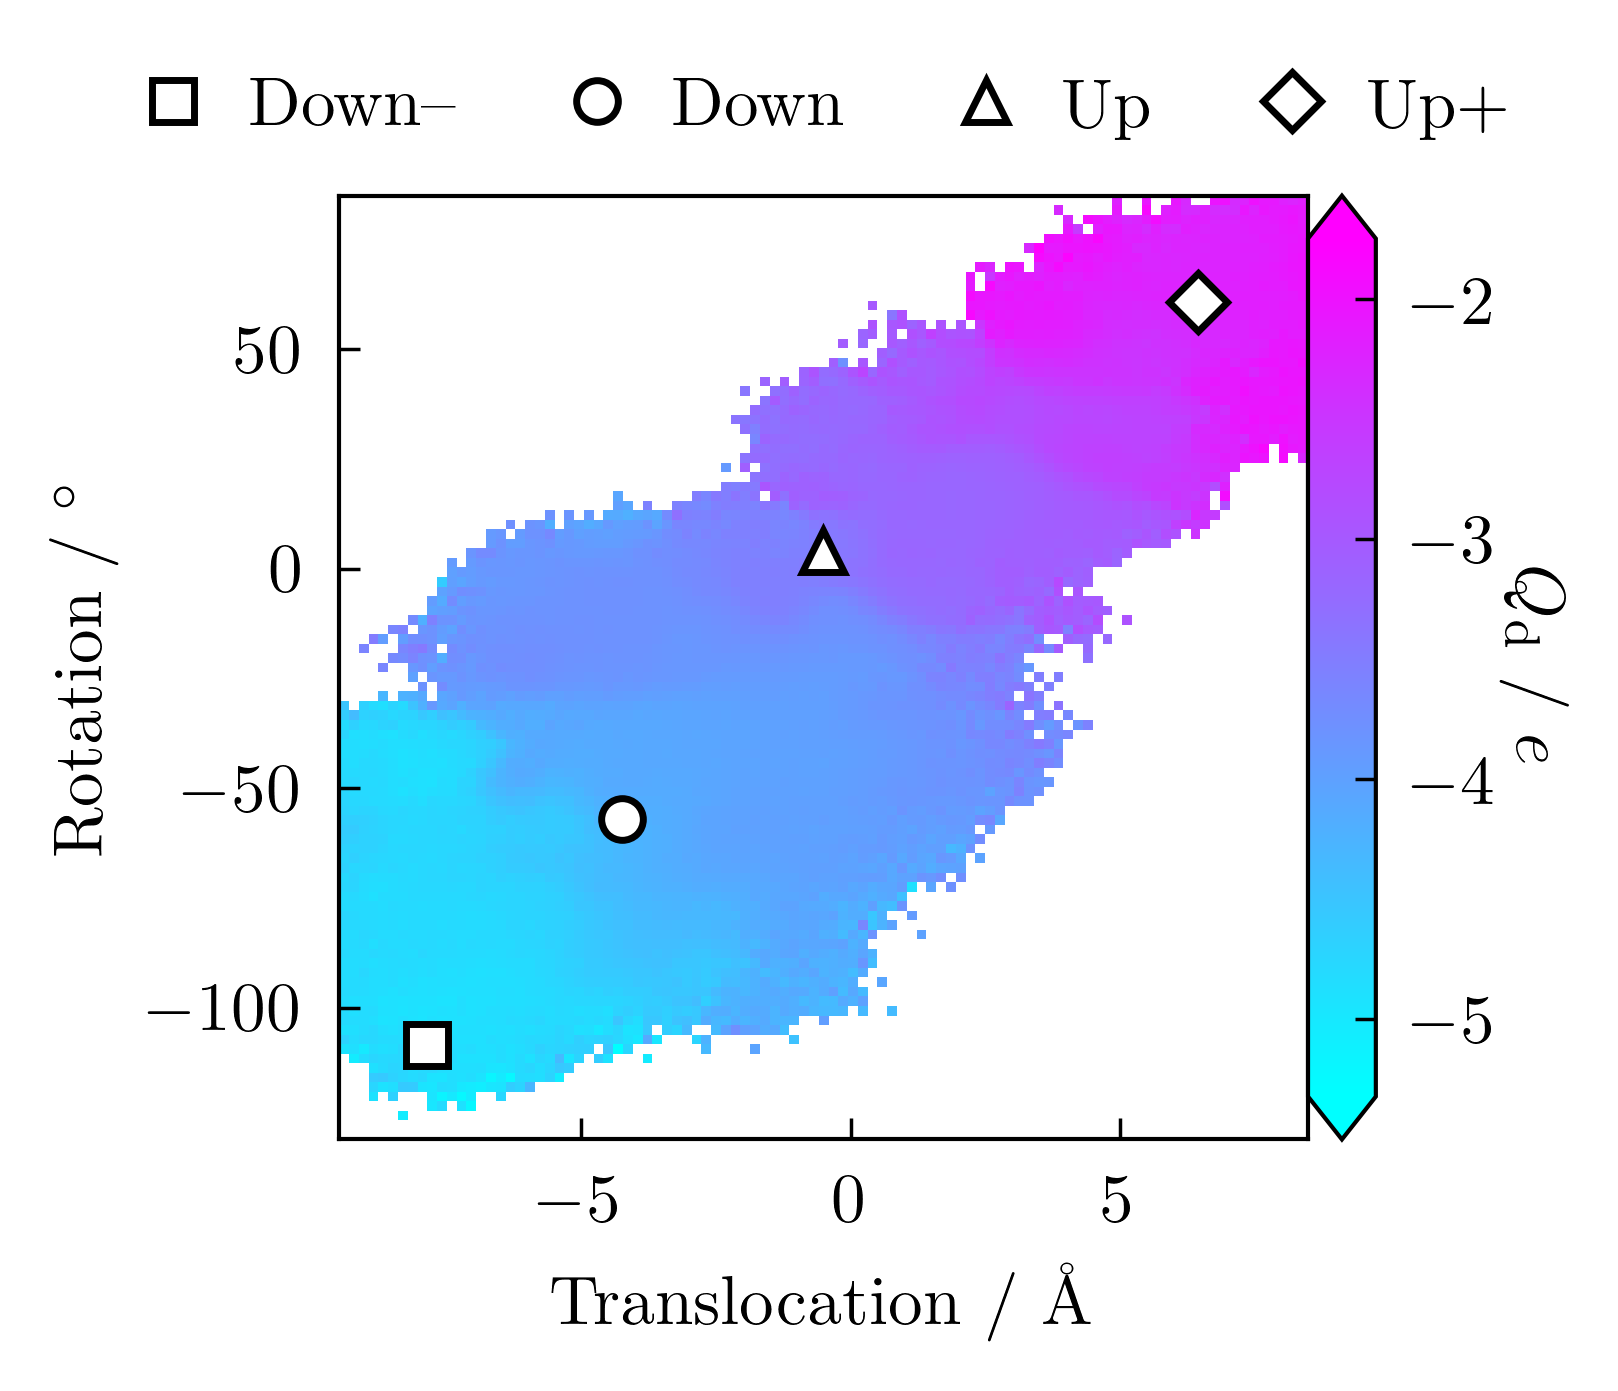

In [7]:
# bin against S4 CVs
dist_trajs = [t[:, 0] for t in cv_trajs]
rot_trajs = [t[:, 1] for t in cv_trajs]
xmin, xmax, ymin, ymax = -9.5, 8.5, -130, 85
xe = np.linspace(xmin, xmax, 100)
ye = np.linspace(ymin, ymax, 100)
dq_binned = extq.projection.average2d(dist_trajs, rot_trajs, dq_trajs, weights, xe, ye)

f = plt.figure(figsize=(2.5, 2.5), dpi=500)
ax = plt.gca()
pc = ax.pcolormesh(xe, ye, dq_binned.T, cmap="cool", rasterized=True)
cb = pplt.colorbar(pc, extend="both")
cb.set_label("$Q_{\\rm d}$ / $e$", rotation=-90, labelpad=10)
plotting.plot_models(ax, models, ms=6, zorder=5)
ax.set_xlabel("Translocation / Å")
ax.set_ylabel("Rotation / $^\circ$")
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
f.legend(
    bbox_to_anchor=(0.5, 0.95),
    loc="center",
    ncol=4,
    labels=["Down–", "Down", "Up", "Up+"],
    handletextpad=0.1,
    columnspacing=1.0,
)
plt.savefig("../../fig/paper/dq_s4.pdf", bbox_inches="tight")

In [8]:
sb_names = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_names.append(f"{r} C$_\\alpha$-{n} C$_\\alpha$")
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        if n.startswith("D"):
            sb_names.append(f"{r} C$_\\zeta$-{n} C$_\\gamma$")
        else:
            sb_names.append(f"{r} C$_\\zeta$-{n} C$_\\delta$")

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in divide
  return numer / denom


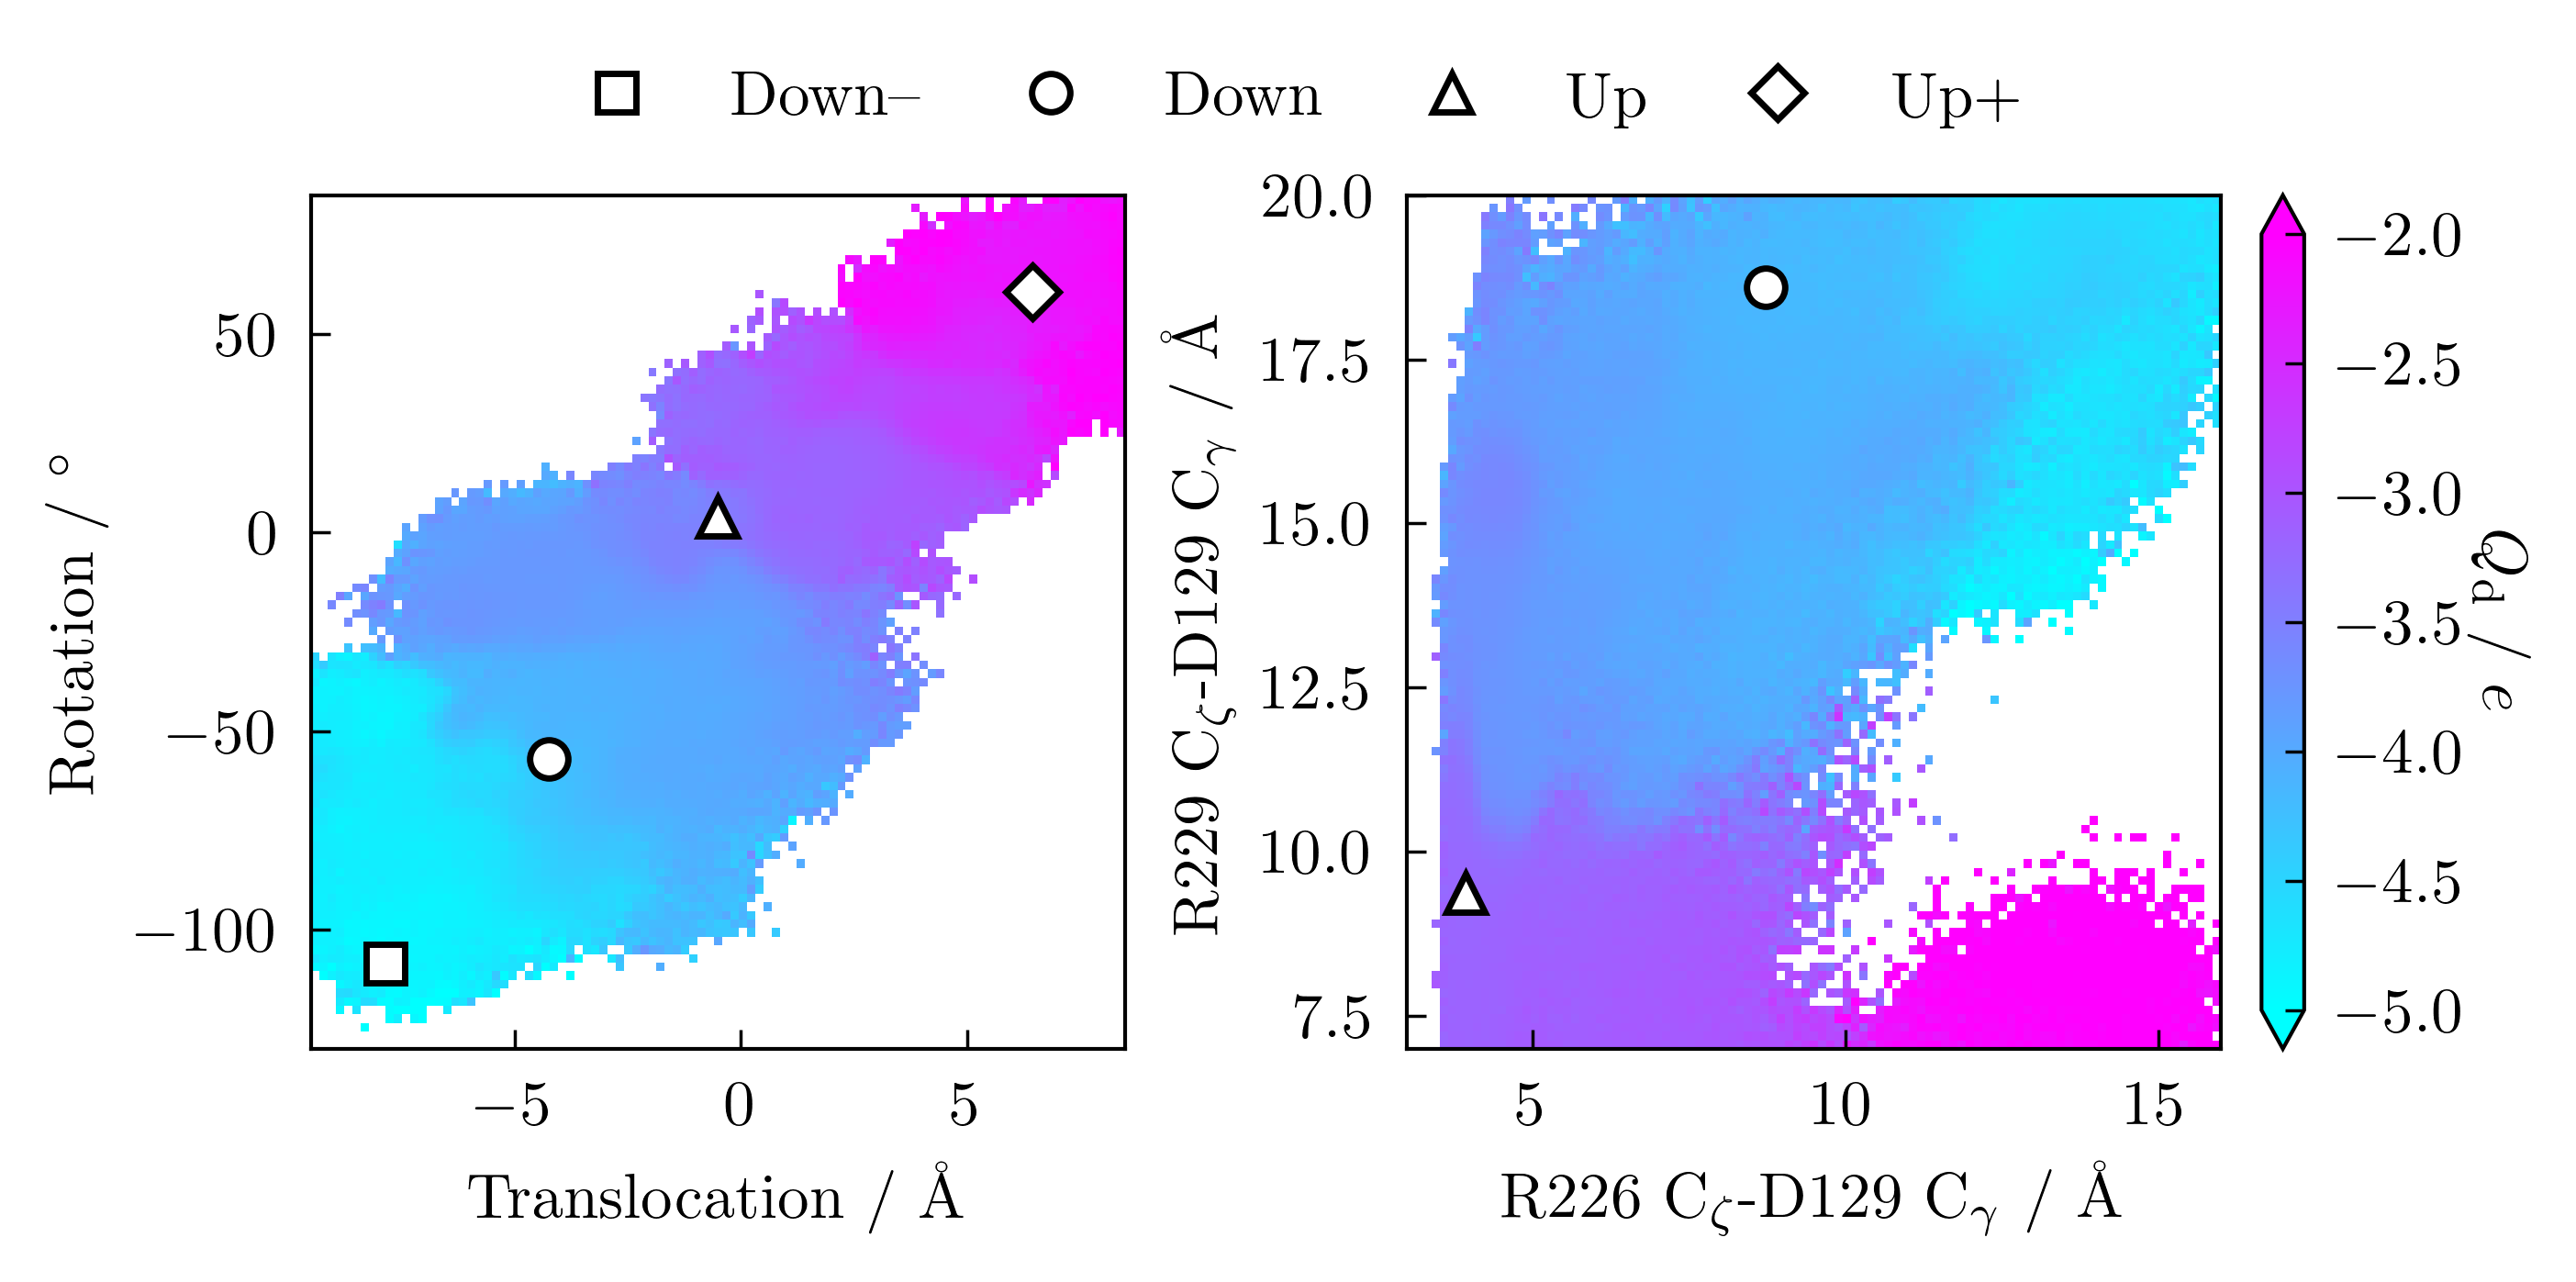

In [9]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(5.5, 2.4), dpi=500, constrained_layout=True)

# bin against S4 CVs
dist_trajs = [t[:, 0] for t in cv_trajs]
rot_trajs = [t[:, 1] for t in cv_trajs]
xmin, xmax, ymin, ymax = -9.5, 8.5, -130, 85
xe = np.linspace(xmin, xmax, 100)
ye = np.linspace(ymin, ymax, 100)
dq_binned = extq.projection.average2d(dist_trajs, rot_trajs, dq_trajs, weights, xe, ye)

pc = ax0.pcolormesh(xe, ye, dq_binned.T, cmap="cool", rasterized=True, vmin=-5, vmax=-2)
# cb = plt.colorbar(pc, ax=ax0, extend="both")
# cb.set_label("$Q_{\\rm d}$ / $e$", rotation=-90, labelpad=10)
plotting.plot_models(ax0, models, ms=6, zorder=5)
ax0.set_xlabel("Translocation / Å")
ax0.set_ylabel("Rotation / $^\circ$")
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymin, ymax])

sb0_trajs = [t[:, 42] * 10 for t in sb_trajs]
sb1_trajs = [t[:, 48] * 10 for t in sb_trajs]
xmin, xmax, ymin, ymax = 3, 16, 7, 20
xe = np.linspace(xmin, xmax, 100)
ye = np.linspace(ymin, ymax, 100)
dq_binned = extq.projection.average2d(sb0_trajs, sb1_trajs, dq_trajs, weights, xe, ye)

pc = ax1.pcolormesh(xe, ye, dq_binned.T, cmap="cool", rasterized=True, vmin=-5, vmax=-2)
cb = plt.colorbar(pc, ax=ax1, extend="both")
cb.set_label("$Q_{\\rm d}$ / $e$", rotation=-90, labelpad=10)
plotting.plot_models(ax1, sb_models[:, [42, 48]] * 10, ms=6, zorder=5)
ax1.set_xlabel(f"{sb_names[42]} / Å")
ax1.set_ylabel(f"{sb_names[48]} / Å")
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymin, ymax])

f.legend(
    bbox_to_anchor=(0.5, 1.05),
    loc="center",
    ncol=4,
    labels=["Down–", "Down", "Up", "Up+"],
    columnspacing=1.0,
)
plt.savefig("../../fig/paper/dq_s4_sb.pdf", bbox_inches="tight")

In [6]:
rq_all = list(np.load("../../data/raw_feat/displacement_rq_0-178.npy"))
rq_all = [t[:, :10000] for t in rq_all]
rq_all.extend(np.load("../../data/raw_feat/displacement_rq_179-185.npy"))
rq_all.extend(np.load("../../data/raw_feat/displacement_rq_185-end.npy"))
print(len(rq_all))

236


/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in true_divide
  return numer / denom
/scratch/local/jobs/4147887/ipykernel_2915195/1066261020.py:25: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7f7dc77ca1c0> has a label of '_' which cannot be automatically added to the legend.
  axs[0, 1].legend(loc='center', bbox_to_anchor=(0.5, 1.15), ncol=4, labels=['_', 'Down–', 'Down', 'Up', 'Up+'], columnspacing=4)


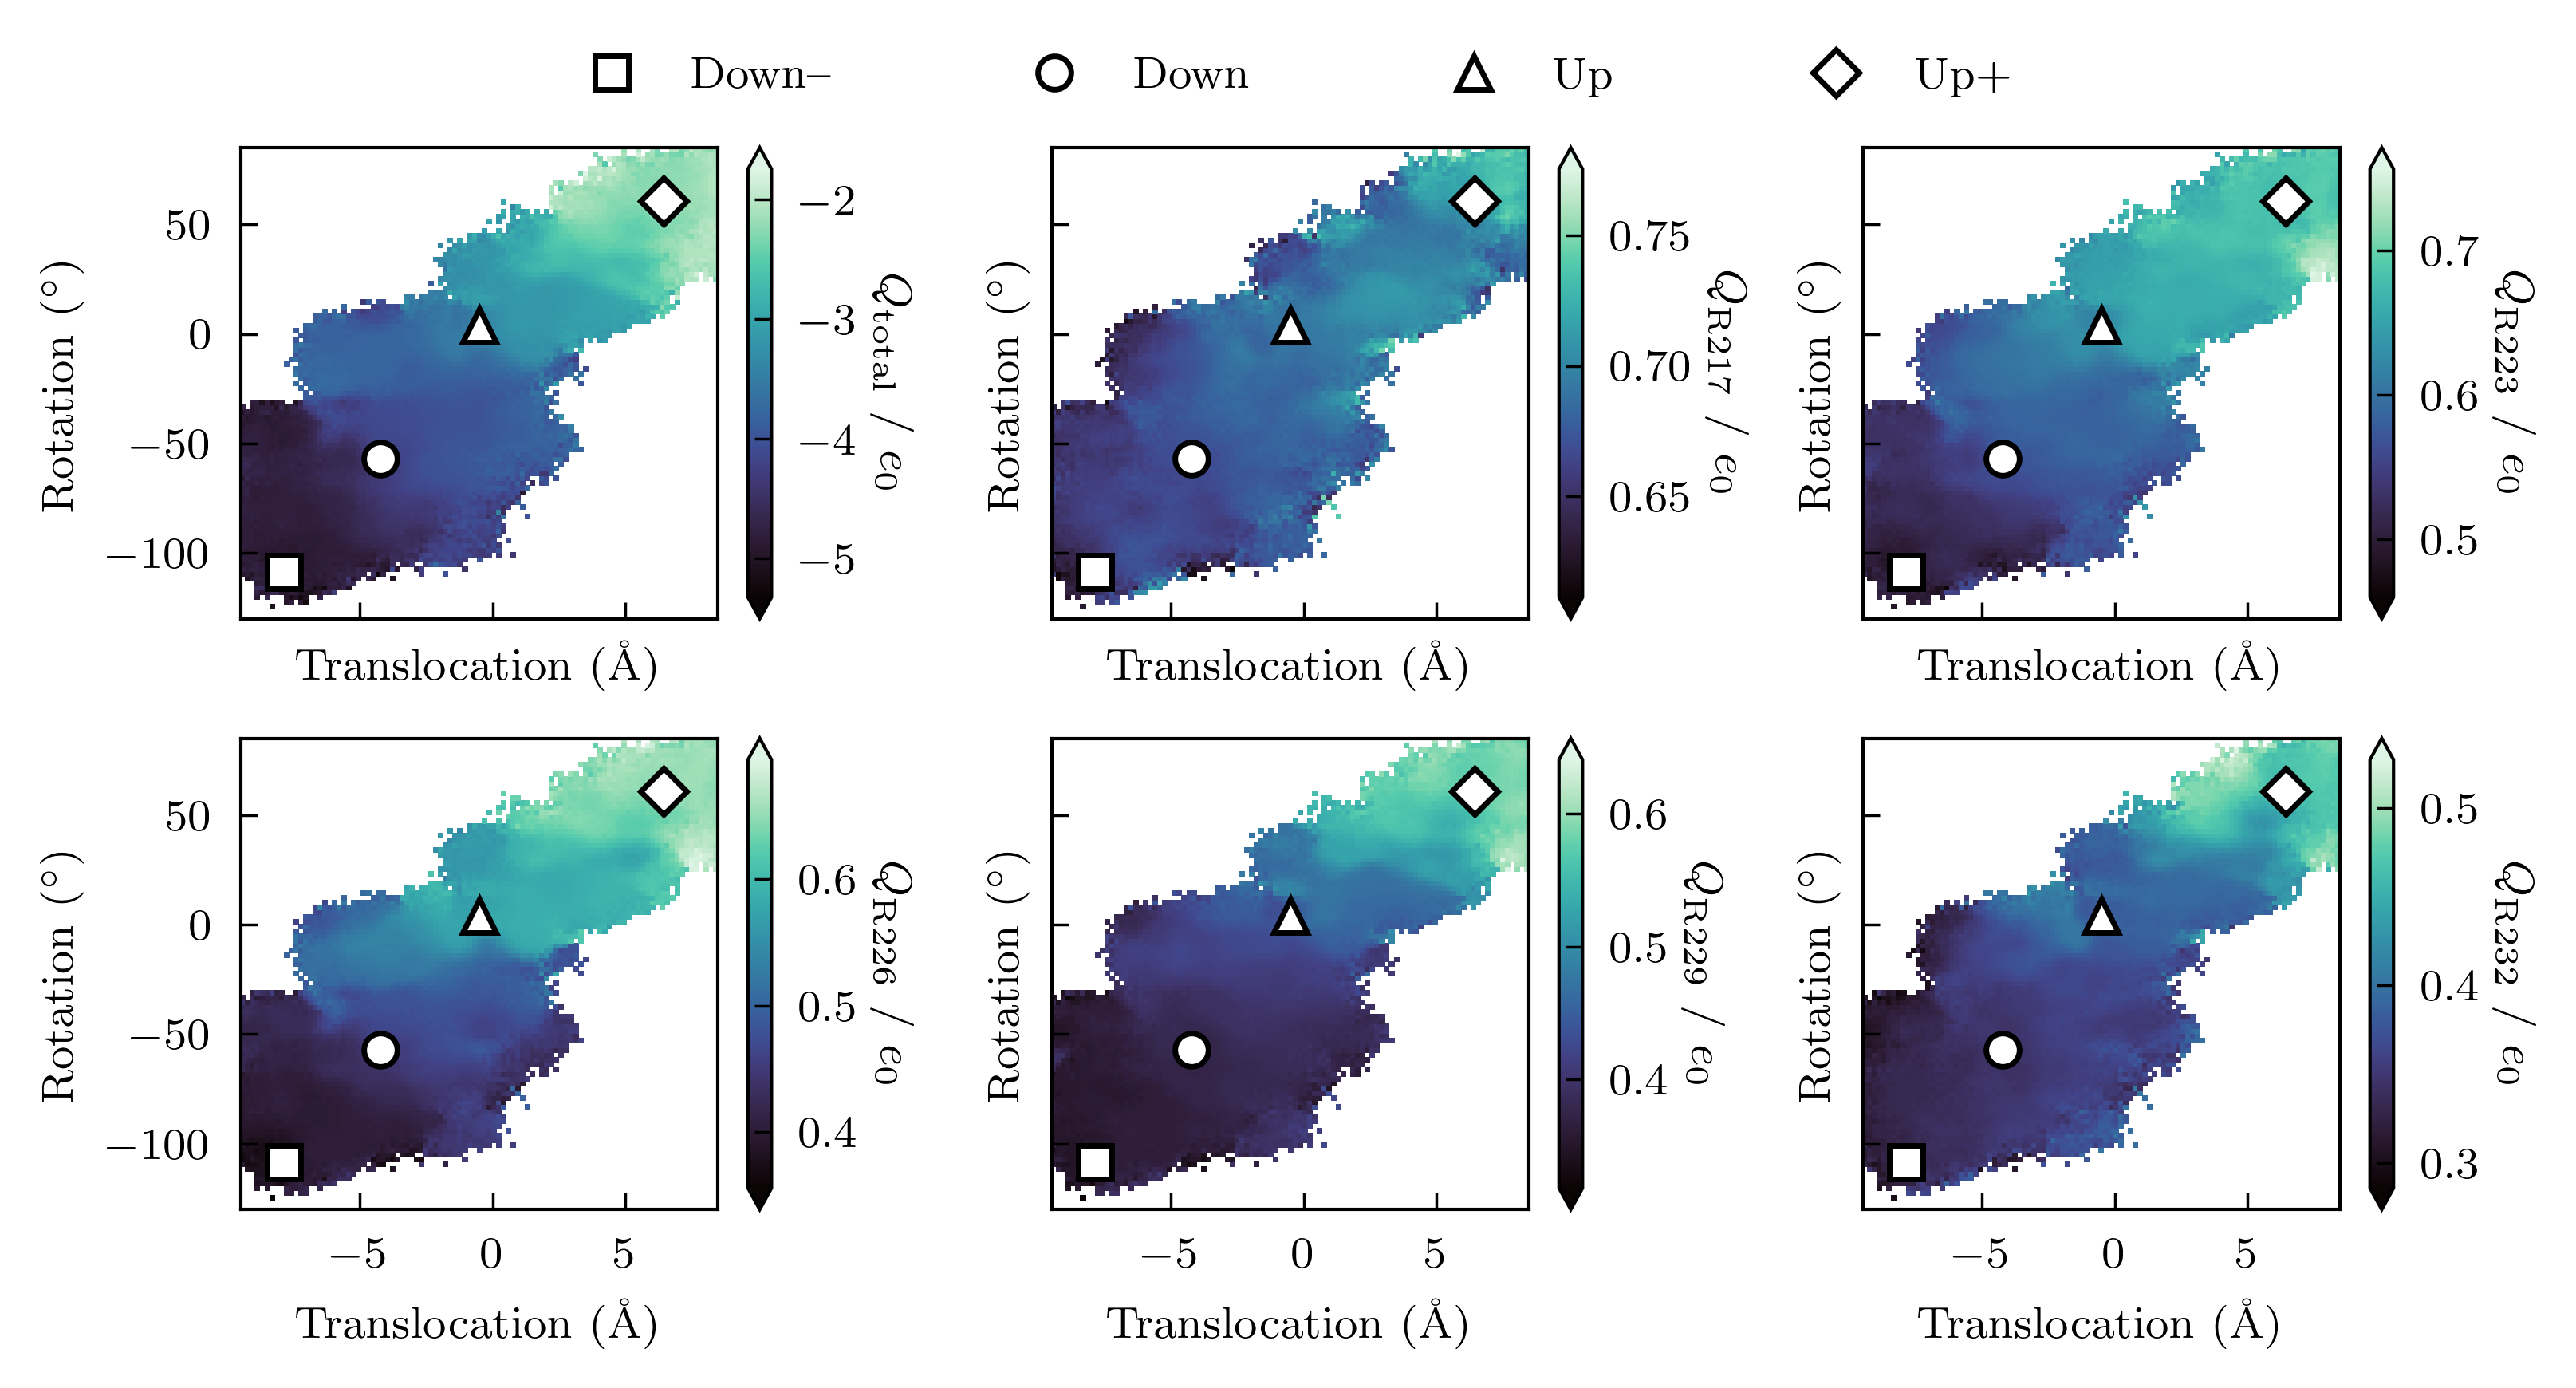

In [32]:
f, axs = plt.subplots(
    2,
    3,
    figsize=(6.5, 3.25),
    dpi=500,
    sharex=True,
    sharey=True,
    constrained_layout=False,
)
h = axs[0, 0].pcolor(xe, ye, dq_binned.T, cmap="mako")
plotting.format_cvs(axs[0, 0], ms=6)
cb = plt.colorbar(h, ax=axs[0, 0], extend="both")
cb.set_label(r"$Q_{\mathrm{total}}$ / $e_0$", rotation=-90, labelpad=10)

cb_titles = (
    r"$Q_{\mathrm{R217}}$ / $e_0$",
    r"$Q_{\mathrm{R223}}$ / $e_0$",
    r"$Q_{\mathrm{R226}}$ / $e_0$",
    r"$Q_{\mathrm{R229}}$ / $e_0$",
    r"$Q_{\mathrm{R232}}$ / $e_0$",
)
for r, ax, title in zip(range(5), axs.flat[1:], cb_titles):
    rq = [t[r, :] for t in rq_all]
    rq_binned = extq.projection.average2d(dist_trajs[:236], rot_trajs[:236], rq, weights[:236], xe, ye)
    h = ax.pcolor(xe, ye, rq_binned.T, cmap="mako")
    plotting.format_cvs(ax, ms=6)
    cb = plt.colorbar(h, ax=ax, extend="both")
    cb.set_label(title, rotation=-90, labelpad=10)

for ax in axs.flat:
    ax.label_outer()
axs[0, 0].set(xlim=[xmin, xmax], ylim=[ymin, ymax])
f.tight_layout()

axs[0, 1].legend(
    loc="center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=4,
    labels=["_", "Down–", "Down", "Up", "Up+"],
    columnspacing=4,
)

# Average with committor

In [9]:
# states to do stopping
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186


# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = ((dist_ax_down**2 + rot_ax_down**2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
)

In [10]:
def mean_std(trajs, ids):
    arr = np.concatenate(trajs)[ids]
    return np.mean(arr), np.std(arr, ddof=1)


down_avg, down_std = mean_std(dq_trajs, down_ids)
up_avg, up_std = mean_std(dq_trajs, up_ids)
print(down_avg, down_std)
print(up_avg, up_std)
print(up_avg - down_avg, np.sqrt(down_std**2 + up_std**2))

-4.173267005463239 0.2344045016775164
-3.287910395167272 0.20684185196073684
0.8853566102959669 0.3126164137233235


In [11]:
traj_inds = util.split_indices(cv_trajs)
in_domain = np.split(~(down_ids | up_ids), traj_inds)

In [12]:
from extq.stop import forward_stop

(0.0, 1.0)

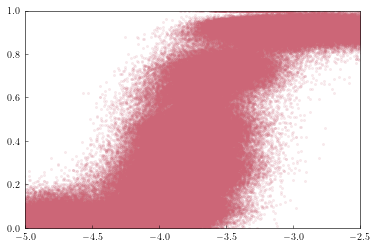

In [14]:
N = len(cv_arr)
skip = 10
inds = random.sample(range(N), N // skip)
dq_samp = np.concatenate(dq_trajs)[inds]
qp_samp = np.concatenate(qp_du)[inds]
s4_samp = dist[inds]
plt.scatter(dq_samp, qp_samp, alpha=0.1)
# plt.colorbar()
plt.xlim([-5, -2.5])
plt.ylim([0, 1])

/scratch/local/jobs/5344163/ipykernel_2140634/2846632315.py:20: RuntimeWarning: invalid value encountered in sqrt
  q_std = np.sqrt(q_avg_sq - q_avg**2)


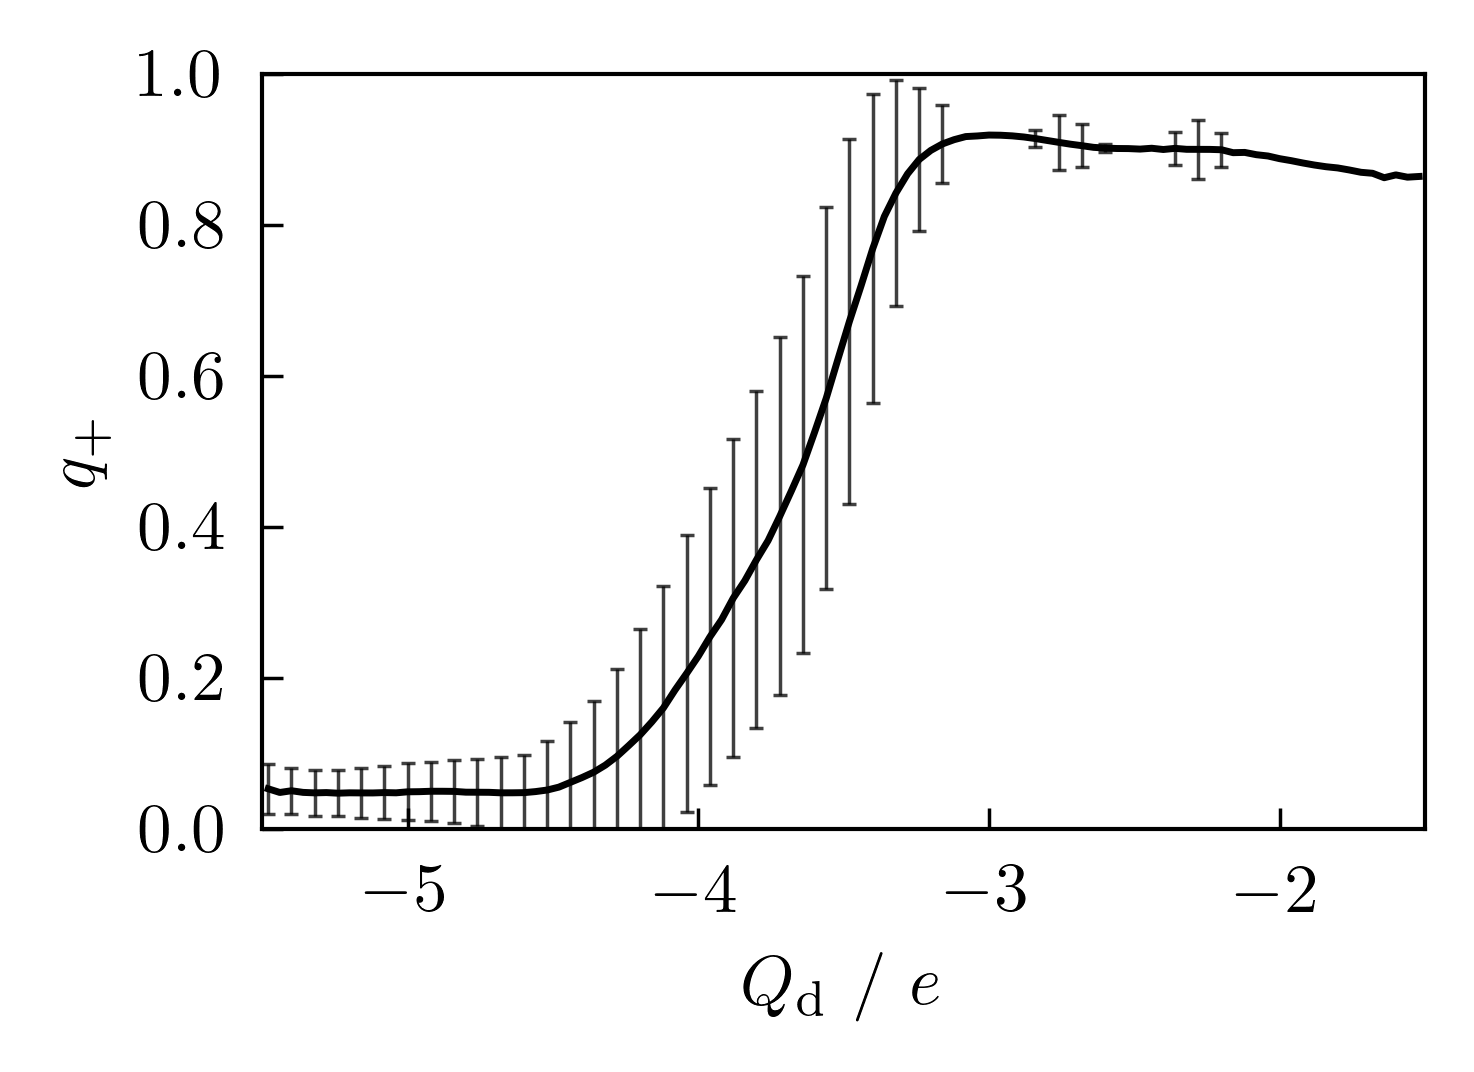

In [15]:
f = plt.figure(figsize=(3.0, 2), dpi=500)
ax = plt.gca()

lo, hi = -5.5, -1.5
qe = np.linspace(lo, hi, 101)
qc = (qe[1:] + qe[:-1]) / 2

lag = 500
qp_delay = []
w_delay = [w[:-lag] for w in weights]
dq_delay = [dq[:-lag] for dq in dq_trajs]
for d, t in zip(in_domain, qp_du):
    # find first stopping time
    stop_times = np.minimum(np.arange(lag, len(d)), forward_stop(d)[:-lag])
    qp_delay.append(t[stop_times])

q_avg = extq.projection.average1d(dq_delay, qp_delay, w_delay, qe)
qp_sq = [q**2 for q in qp_du]
q_avg_sq = extq.projection.average1d(dq_trajs, qp_sq, weights, qe)
q_std = np.sqrt(q_avg_sq - q_avg**2)

ax.plot(qc, q_avg, color="black", lw=1.0)
# ax.fill_between(qc, q_avg - q_std, q_avg + q_std, color='C0', alpha=0.5)
ax.errorbar(
    qc,
    q_avg,
    yerr=q_std,
    color="black",
    elinewidth=0.5,
    capsize=1.0,
    capthick=0.5,
    errorevery=2,
    alpha=0.75,
    zorder=1,
)
ax.set_ylabel("$q_+$")
ax.set_xlabel("$Q_{\\rm d}$ / $e$")
ax.set_xlim([lo, hi])
ax.set_ylim([0, 1])
# ax.axvspan(
#     down_avg - down_std, down_avg + down_std, color="#364B9A", alpha=0.5, zorder=0, ec=None
# )
# ax.axvspan(up_avg - up_std, up_avg + up_std, color="#A50026", alpha=0.5, zorder=0, ec=None)
plt.savefig("../../fig/paper/dq_qp.pdf", bbox_inches="tight")

/scratch/local/jobs/293176/ipykernel_1094108/2066791958.py:20: RuntimeWarning: invalid value encountered in sqrt
  dq_std = np.sqrt(dq_avg_sq - dq_avg ** 2)


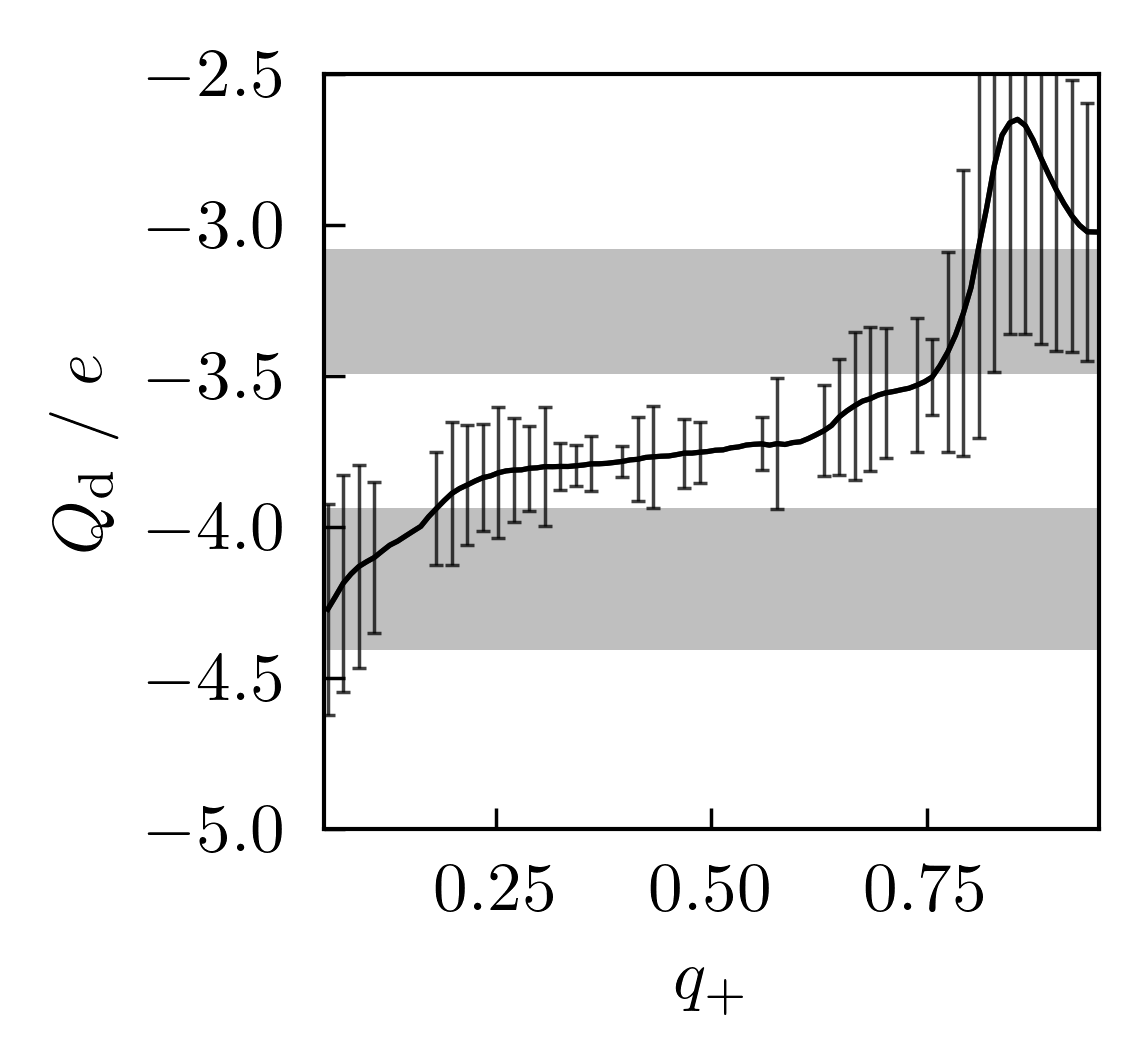

In [21]:
f = plt.figure(figsize=(2.0, 2), dpi=500)
ax = plt.gca()

lo, hi = 0.05, 0.95
qe = np.linspace(lo, hi, 101)
qc = (qe[1:] + qe[:-1]) / 2

lag = 500
qp_delay = []
w_delay = [w[:-lag] for w in weights]
dq_delay = [dq[:-lag] for dq in dq_trajs]
for d, t in zip(in_domain, qp_du):
    # find first stopping time
    stop_times = np.minimum(np.arange(lag, len(d)), forward_stop(d)[:-lag])
    qp_delay.append(t[stop_times])

dq_avg = extq.projection.average1d(qp_delay, dq_delay, w_delay, qe)
dq_sq = [dq**2 for dq in dq_trajs]
dq_avg_sq = extq.projection.average1d(qp_du, dq_sq, weights, qe)
dq_std = np.sqrt(dq_avg_sq - dq_avg**2)

ax.plot(qc, dq_avg, color="black")
ax.errorbar(
    qc,
    dq_avg,
    yerr=dq_std,
    color="black",
    elinewidth=0.5,
    capsize=1.0,
    capthick=0.5,
    errorevery=2,
    alpha=0.75,
    zorder=1,
)
ax.set_xlabel("$q_+$")
ax.set_ylabel("$Q_{\\rm d}$ / $e$")
ax.set_xlim([lo, hi])
ax.set_ylim([-5, -2.5])
ax.axhspan(down_avg - down_std, down_avg + down_std, color="gray", alpha=0.5, zorder=0, ec=None)
ax.axhspan(up_avg - up_std, up_avg + up_std, color="gray", alpha=0.5, zorder=0, ec=None)

In [13]:
def bin_inds(q, qstep=0.05, low=0, hi=1):
    q_arr = np.concatenate(q)
    nsteps = round((hi - low) / qstep)
    all_inds = []
    steps = np.linspace(low, hi - qstep, nsteps)
    for i, s in enumerate(steps):
        q_inds = ((q_arr >= s) & (q_arr <= s + qstep)).nonzero()[0]
        all_inds.append(q_inds)
    return steps, all_inds

/scratch/local/jobs/4414590/ipykernel_2849157/1969865470.py:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("../../fig/paper/dq_violins.pdf", bbox_inches="tight", padding=0.2)


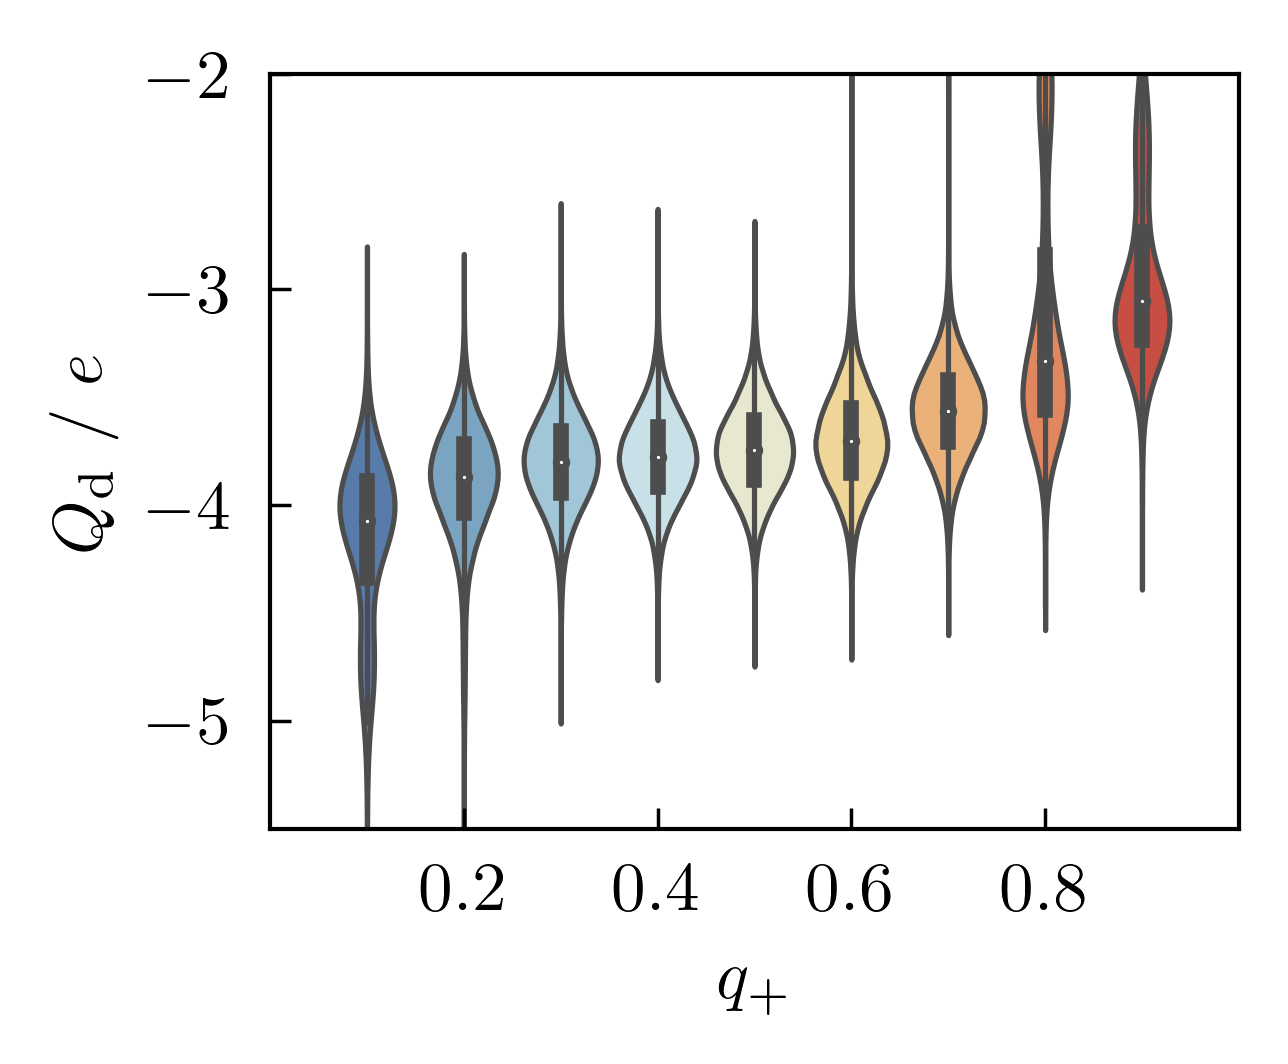

In [19]:
f, ax = plt.subplots(figsize=(2.5, 2.0), dpi=500)

steps, q_inds = bin_inds(qp_du, qstep=0.1, low=0.05, hi=0.95)
steplabels = []
for i, s in enumerate(steps):
    steplabels.append(f"{s+0.05:.1f}")

sns.violinplot(
    ax=ax,
    data=[np.concatenate(dq_trajs)[inds] for inds in q_inds],
    palette="diverging",
    scale="area",
    bw=0.1,
    inner="box",
)
ax.set_xticks(np.arange(9)[1::2], steplabels[1::2])
ax.set_ylabel("$Q_{\\rm d}$ / $e$")
ax.set_xlim([-1, 9])
ax.set_ylim([-5.5, -2])
ax.set_xlabel("$q_+$")
plt.savefig("../../fig/paper/dq_violins.pdf", bbox_inches="tight", padding=0.2)

(-0.5, 5.0)

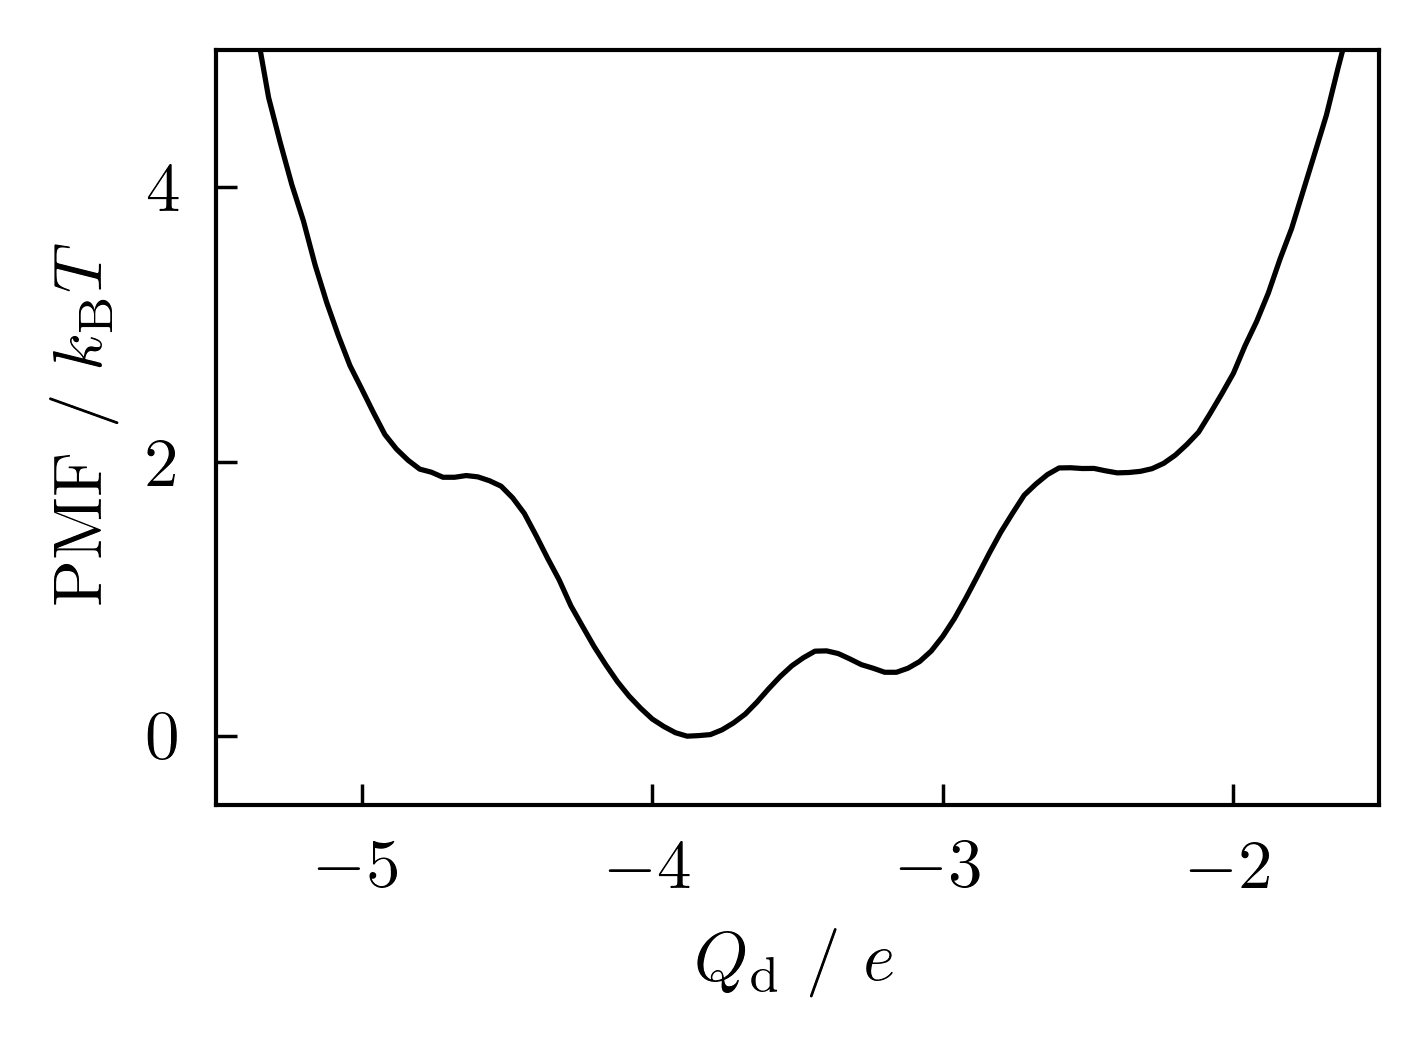

In [15]:
# PMF along Q_d
f = plt.figure(figsize=(3.0, 2), dpi=500)
ax = plt.gca()

lo, hi = -5.5, -1.5
qe = np.linspace(lo, hi, 101)
qc = (qe[1:] + qe[:-1]) / 2

w_delay = [w[:-lag] for w in weights]
dq_delay = [dq[lag:] for dq in dq_trajs]

dens = extq.projection.density1d(dq_delay, w_delay, qe)
min_e = np.min(-np.log(dens[np.nonzero(dens)]))
pmf = -np.log(dens) - min_e
ax.plot(qc, pmf, color="black")
ax.set_ylabel("PMF / $k_{\mathrm B}T$")
ax.set_xlabel("$Q_{\\rm d}$ / $e$")
ax.set_xlim([lo, hi])
ax.set_ylim([-0.5, 5])
# ax.axvspan(
#     down_avg - down_std, down_avg + down_std, color="#364B9A", alpha=0.5, zorder=0, ec=None
# )
# ax.axvspan(up_avg - up_std, up_avg + up_std, color="#A50026", alpha=0.5, zorder=0, ec=None)
# plt.savefig("../../fig/paper/dq_pmf.pdf", bbox_inches="tight")

/scratch/local/jobs/4512569/ipykernel_1136534/2963990971.py:20: RuntimeWarning: invalid value encountered in sqrt
  q_std = np.sqrt(q_avg_sq - q_avg**2)


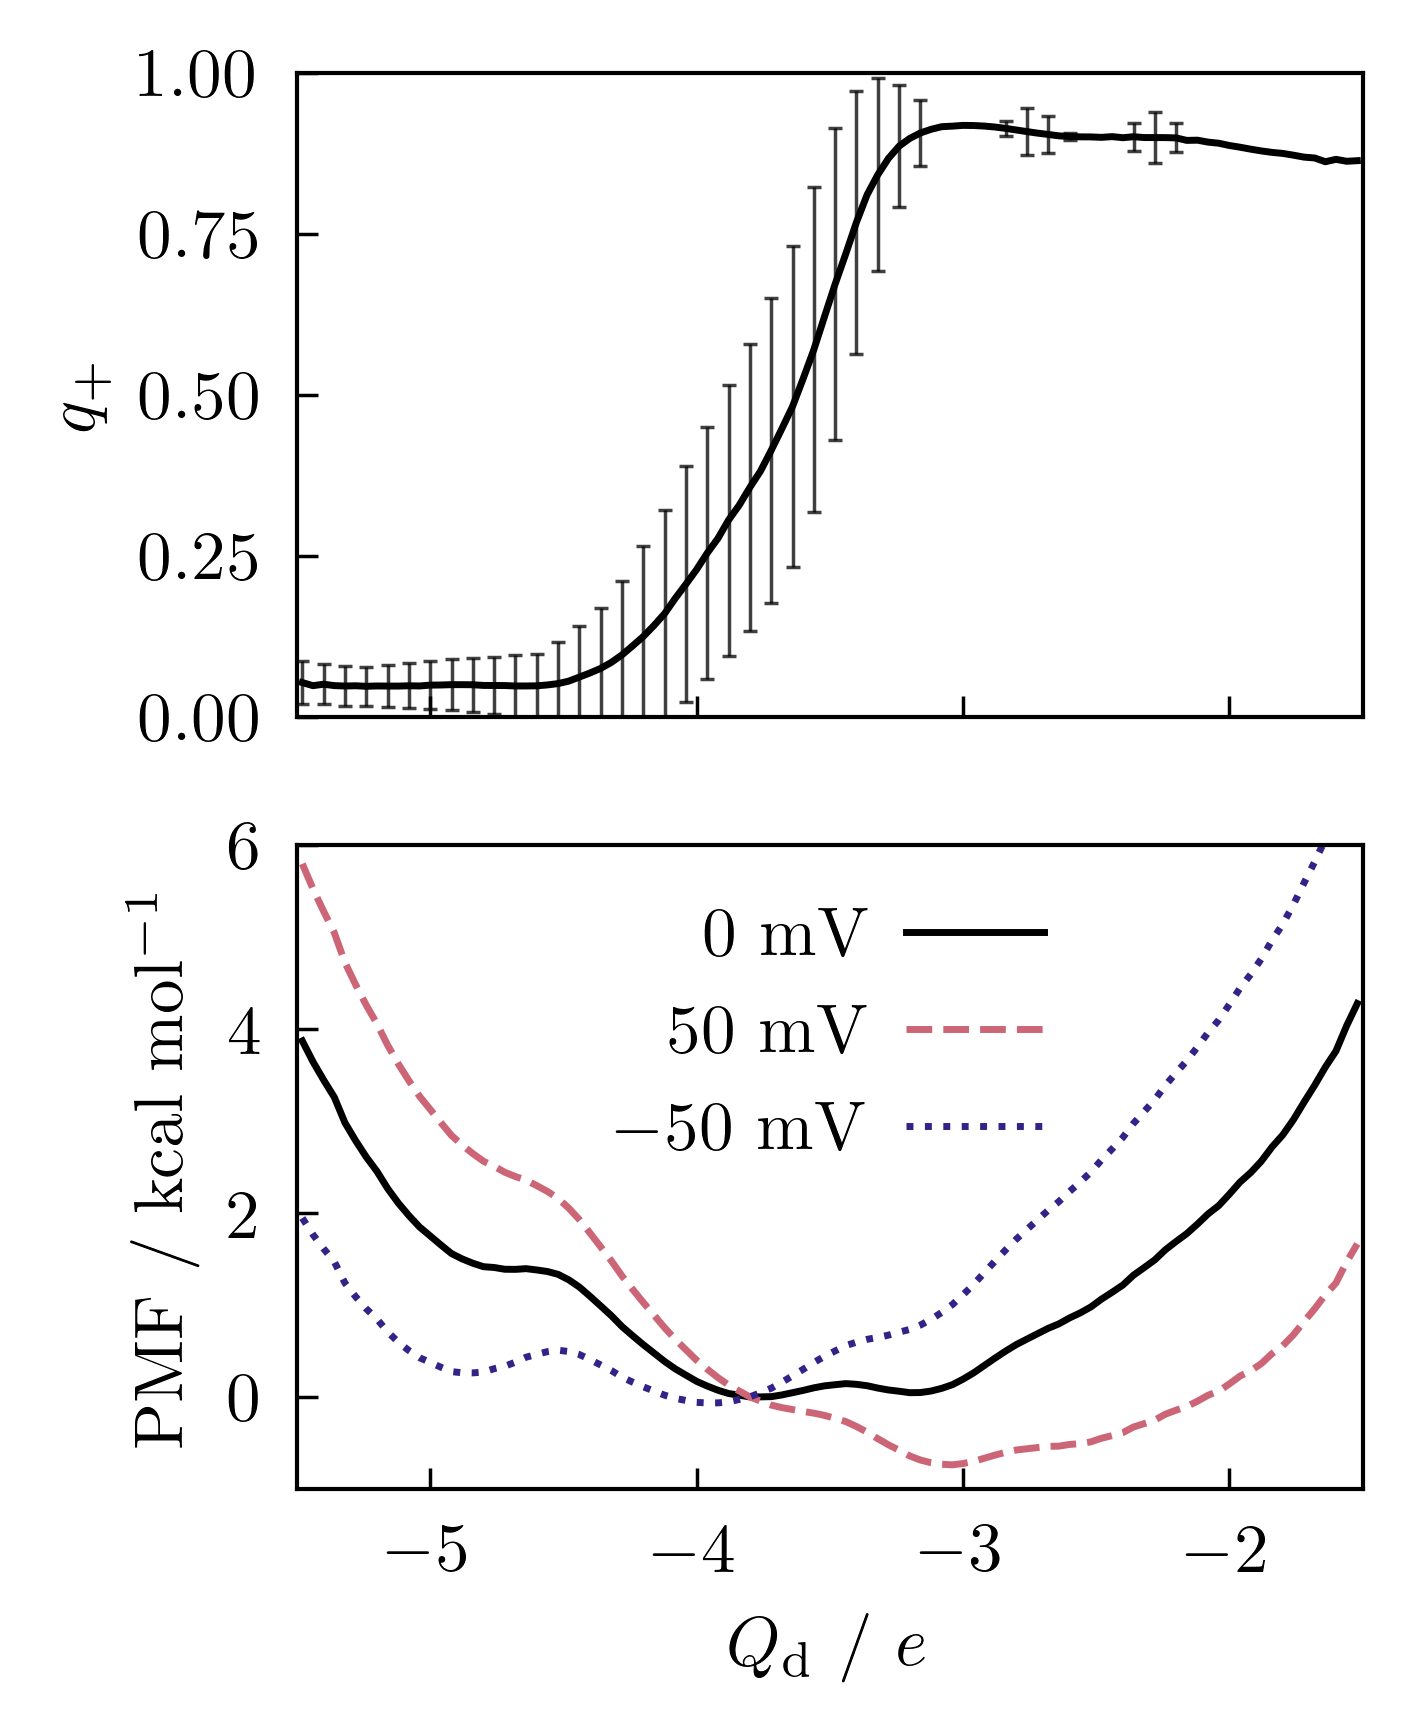

In [17]:
# PMF along Q_d with differing voltage biases
f, (ax0, ax1) = plt.subplots(nrows=2, figsize=(2.75, 3.75), dpi=500, sharex=True)

lo, hi = -5.5, -1.5
qe = np.linspace(lo, hi, 101)
qc = (qe[1:] + qe[:-1]) / 2

lag = 500
qp_delay = []
w_delay = [w[:-lag] for w in weights]
dq_delay = [dq[:-lag] for dq in dq_trajs]
for d, t in zip(in_domain, qp_du):
    # find first stopping time
    stop_times = np.minimum(np.arange(lag, len(d)), forward_stop(d)[:-lag])
    qp_delay.append(t[stop_times])

q_avg = extq.projection.average1d(dq_delay, qp_delay, w_delay, qe)
qp_sq = [q**2 for q in qp_du]
q_avg_sq = extq.projection.average1d(dq_trajs, qp_sq, weights, qe)
q_std = np.sqrt(q_avg_sq - q_avg**2)

ax0.plot(qc, q_avg, color="black", lw=1.0)
# ax.fill_between(qc, q_avg - q_std, q_avg + q_std, color='C0', alpha=0.5)
ax0.errorbar(
    qc,
    q_avg,
    yerr=q_std,
    color="black",
    elinewidth=0.5,
    capsize=1.0,
    capthick=0.5,
    errorevery=2,
    alpha=0.75,
    zorder=1,
)
ax0.set_ylabel("$q_+$")
ax0.set_ylim([0, 1])

w_delay = [w[:-lag] for w in weights]
dq_delay = [dq[lag:] for dq in dq_trajs]
dens = extq.projection.density1d(dq_delay, w_delay, qe)
min_e = np.min(-np.log(dens[np.nonzero(dens)]))
pmf = -np.log(dens) - min_e

voltage1, voltage2, voltage3 = 50, -50, 20  # mV
offset = qc[np.argmin(pmf)]
bias1 = (qc - offset) * voltage1 * 0.03868  # convert to kT @ 300K
bias2 = (qc - offset) * voltage2 * 0.03868
bias3 = (qc - offset) * voltage3 * 0.03868

with mpl.rc_context({"lines.linewidth": 1.0}):
    ax1.plot(qc, pmf * 0.593, color="black", label="0 mV")
    ax1.plot(qc, (pmf - bias1) * 0.593, "--", color="C0", label=f"${voltage1}$ mV")
    ax1.plot(qc, (pmf - bias2) * 0.593, ":", color="C1", label=f"${voltage2}$ mV")
    # ax1.plot(qc, pmf - bias3, "-.", color="C3", label=f"${voltage3}$ mV")

# ax1.set_ylabel("PMF / $k_{\mathrm B}T$")
ax1.set_ylabel("PMF / kcal mol$^{-1}$")
ax1.set_xlabel("$Q_{\\rm d}$ / $e$")
ax1.set_xlim([lo, hi])
ax1.set_ylim([-1, 6])
pplt.legend(
    axs=ax1,
    ax=ax1,
    ncol=1,
    markerfirst=False,
    columnspacing=0.5,
    handletextpad=0.5,
    loc="upper center"
    # frameon=True,
    # facecolor="white",
    # fancybox=False,
)
plt.savefig("../../fig/paper/dq_pmf_bias.pdf", bbox_inches="tight")

In [18]:
downcolor = "#4764cc"
upcolor = "#cc0030"

/scratch/local/jobs/6124319/ipykernel_3144317/1390869797.py:39: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(pmf) - min_energy


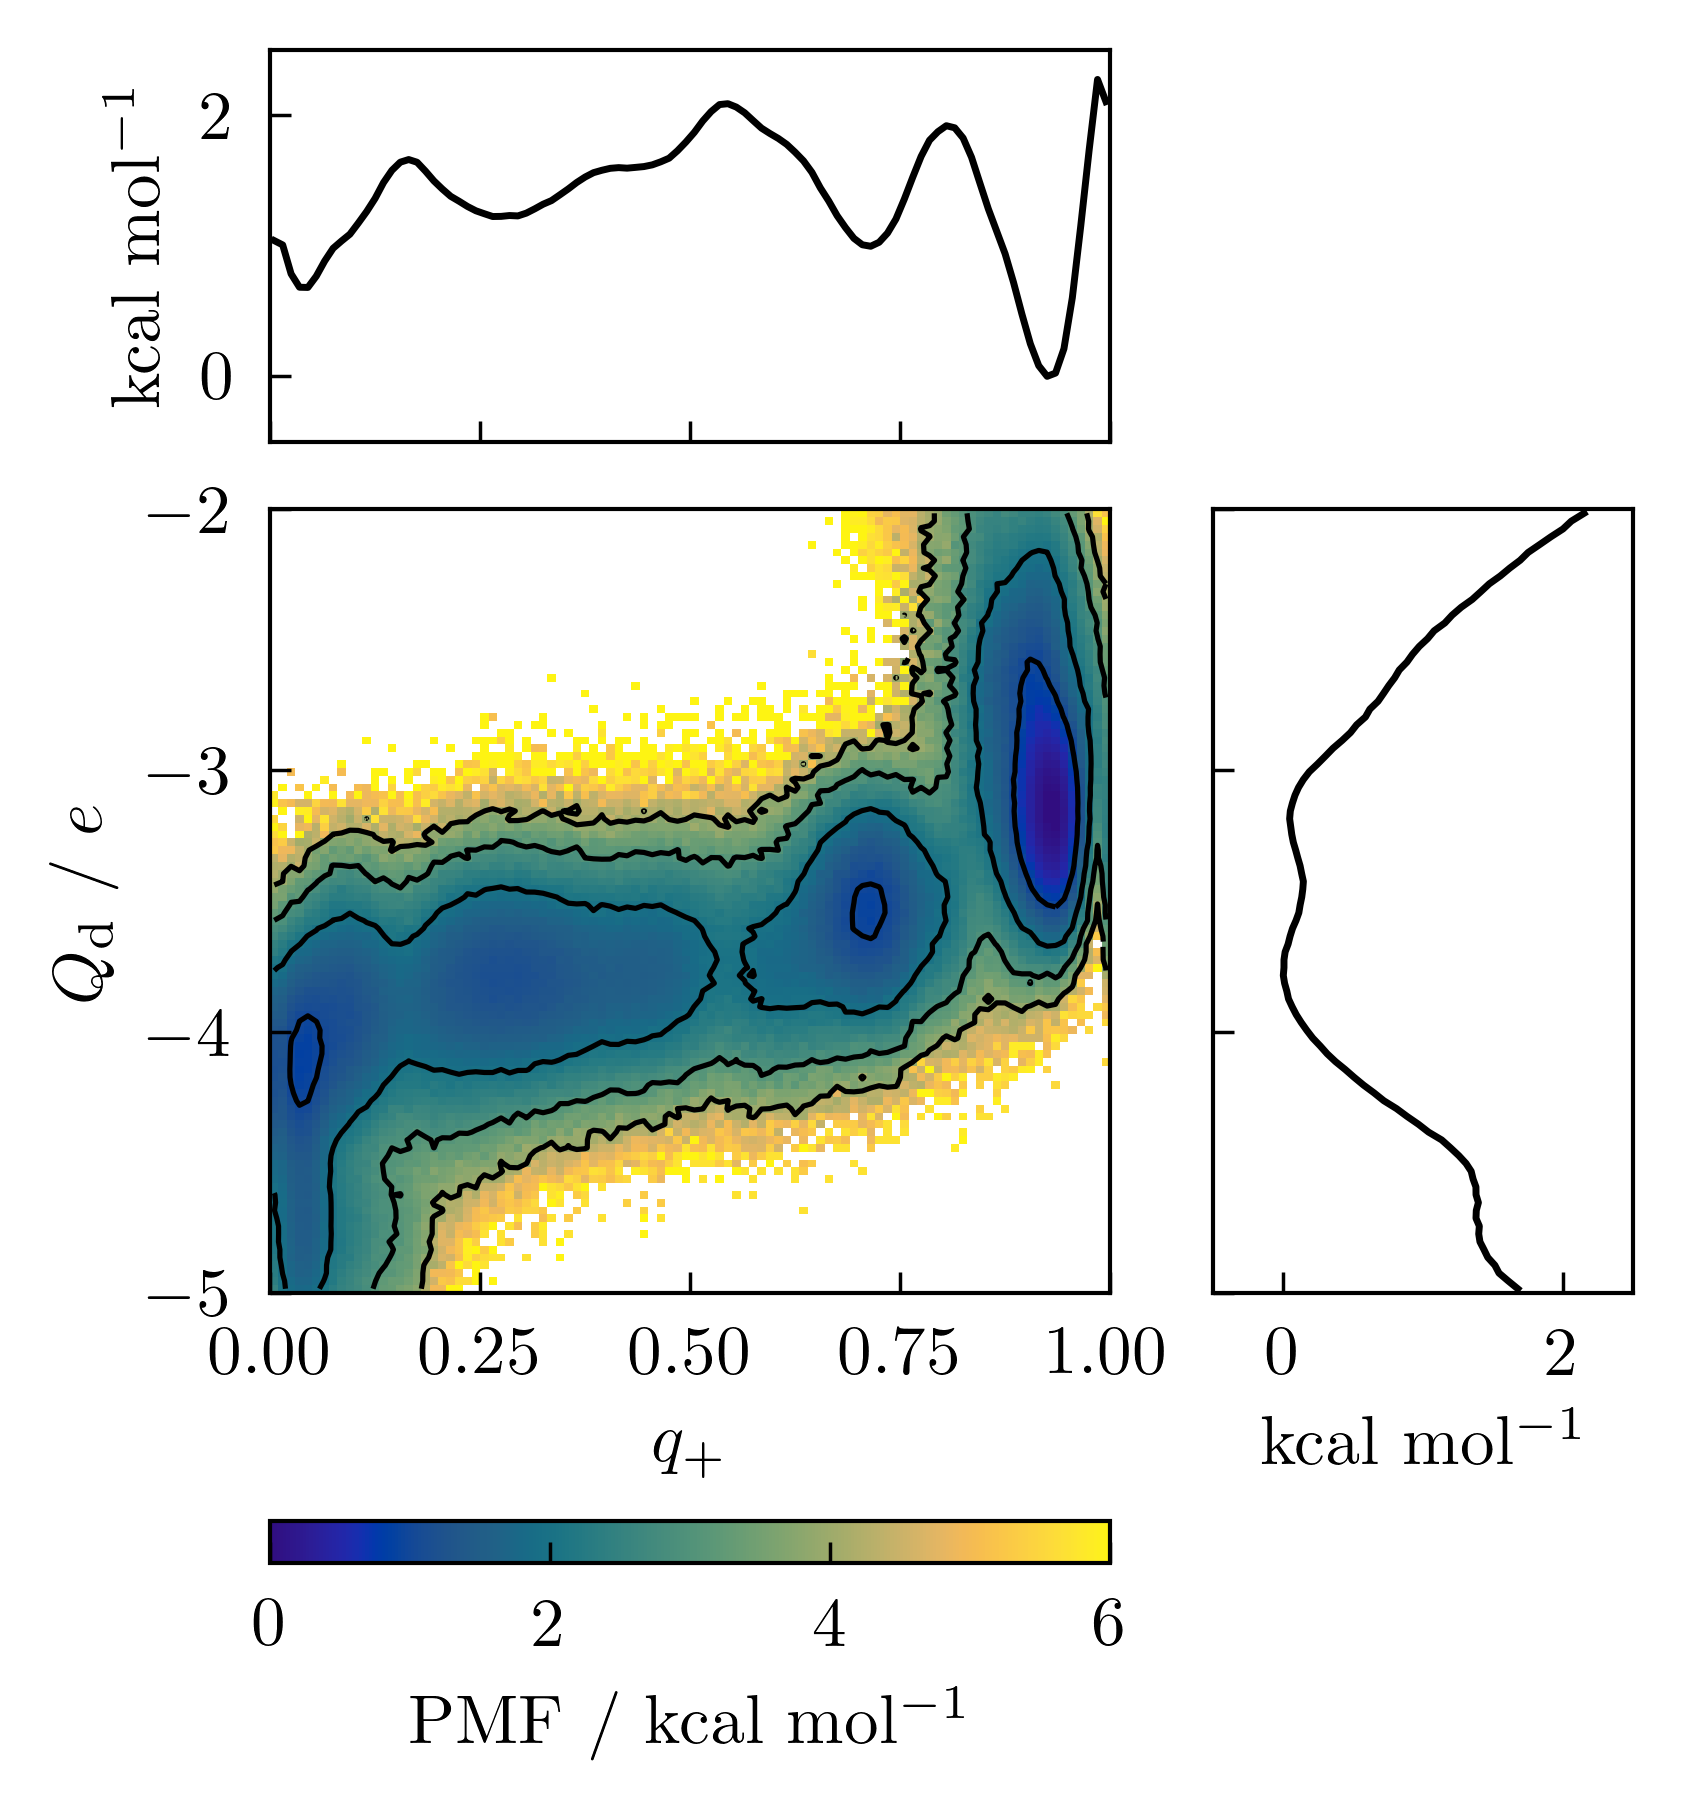

In [14]:
fig = plt.figure(figsize=(3.25, 3.5), dpi=500, constrained_layout=True)
gs = fig.add_gridspec(
    2,
    2,
    width_ratios=(2, 1),
    height_ratios=(1, 2),
    left=0.1,
    right=0.9,
    bottom=0.1,
    top=0.9,
    wspace=0.05,
    hspace=0.05,
)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

lo, hi = 0, 1
qe = np.linspace(lo, hi, 101)
qc = (qe[1:] + qe[:-1]) / 2

lo, hi = -5.0, -2
dqe = np.linspace(lo, hi, 101)
dqc = (dqe[1:] + dqe[:-1]) / 2

dens = extq.projection.density1d(qp_du, weights, qe)
min_e = np.min(-np.log(dens[np.nonzero(dens)]))
q_pmf = -np.log(dens) - min_e

dens = extq.projection.density1d(dq_trajs, weights, dqe)
min_e = np.min(-np.log(dens[np.nonzero(dens)]))
dq_pmf = -np.log(dens) - min_e

w_delay = [w[:-lag] for w in weights]
qp_delay = [t[lag:] for t in qp_du]
dq_delay = [t[lag:] for t in dq_trajs]
pmf = extq.projection.density2d(qp_delay, dq_delay, w_delay, qe, dqe)
min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = -np.log(pmf) - min_energy


pc0 = ax.pcolormesh(qe, dqe, diff.T * 0.593, cmap="macaw", vmin=0, vmax=6, rasterized=True)
ax.contour(qc, dqc, diff.T * 0.593, levels=np.arange(5), colors='black')
plt.colorbar(pc0, ax=ax, location="bottom", label="PMF / kcal mol$^{-1}$")
# ax.axhline(down_avg, ls="--", color=downcolor, label="Down", lw=1.5)
# ax.axhline(up_avg, ls=":", color=upcolor, label="Up", lw=1.5)
ax.set_ylabel("$Q_{\\rm d}$ / $e$")
ax.set_xlabel("$q_+$")
# ax.set_yticks(np.arange(-5, -2, 1))
# ax.invert_yaxis()
ax.set_ylim([-5, -2])
# ax.legend(loc="upper left")

# ax_histx.axhline(down_avg, ls="--", color=downcolor, label="Down", lw=1.5)
# ax_histx.axhline(up_avg, ls=":", color=upcolor, label="Up", lw=1.5)
with mpl.rc_context({"lines.linewidth": 1.0}):
    ax_histx.plot(qc, q_pmf * 0.593, color="black")
    ax_histy.plot(dq_pmf * 0.593, dqc, color="black")
ax_histx.set_ylim([-0.5, 2.5])
ax_histy.set_xlim([-0.5, 2.5])
# ax_histy.invert_xaxis()
ax_histx.set_ylabel("kcal mol$^{-1}$")
ax_histy.set_xlabel("kcal mol$^{-1}$")
ax_histx.label_outer()
ax_histy.label_outer()
plt.savefig("../../fig/paper/dq_qp_pmf.pdf", bbox_inches="tight")

/scratch/local/jobs/4183472/ipykernel_625968/528033266.py:32: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(pmf) - min_energy


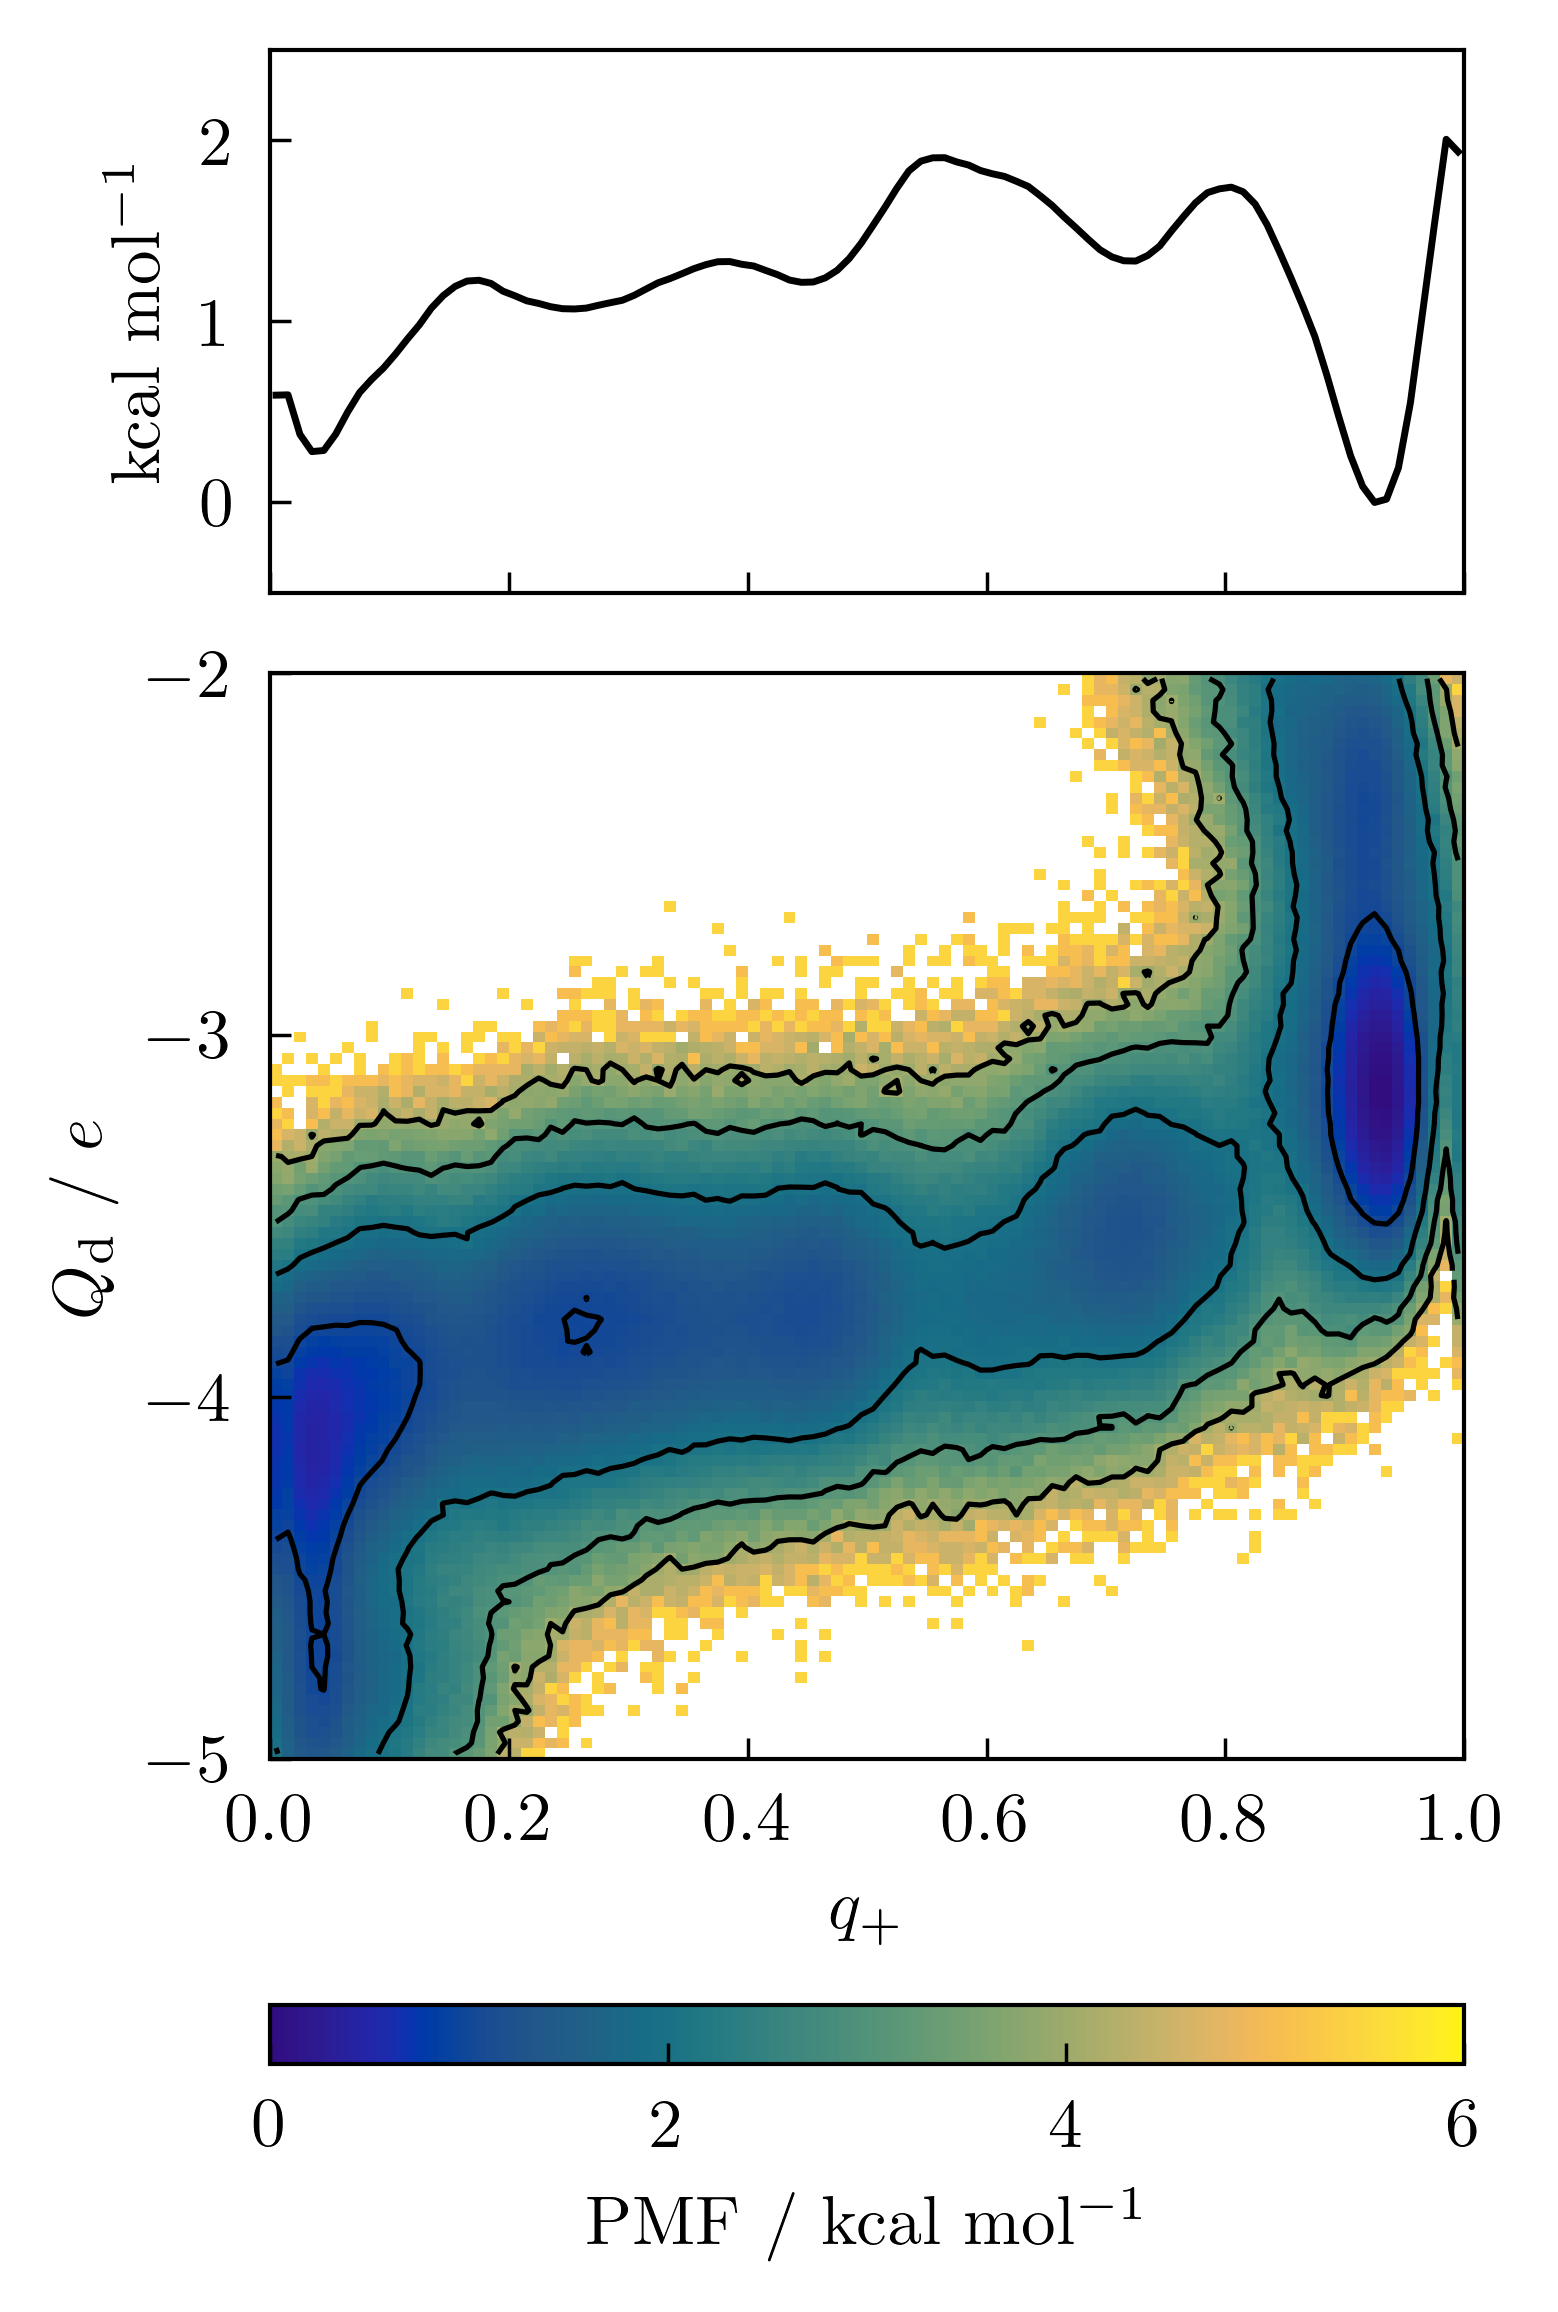

In [32]:
fig = plt.figure(figsize=(3., 4.5), dpi=500, constrained_layout=True)
gs = fig.add_gridspec(
    2,
    1,
    height_ratios=(1, 2),
    left=0.1,
    right=0.9,
    bottom=0.1,
    top=0.9,
    hspace=0.05,
)
ax = fig.add_subplot(gs[1])
ax_histx = fig.add_subplot(gs[0], sharex=ax)

lo, hi = 0, 1
qe = np.linspace(lo, hi, 101)
qc = (qe[1:] + qe[:-1]) / 2

lo, hi = -5.0, -2
dqe = np.linspace(lo, hi, 101)
dqc = (dqe[1:] + dqe[:-1]) / 2

dens = extq.projection.density1d(qp_du, weights, qe)
min_e = np.min(-np.log(dens[np.nonzero(dens)]))
q_pmf = -np.log(dens) - min_e

w_delay = [w[:-lag] for w in weights]
qp_delay = [t[lag:] for t in qp_du]
dq_delay = [t[lag:] for t in dq_trajs]
pmf = extq.projection.density2d(qp_delay, dq_delay, w_delay, qe, dqe)
min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = -np.log(pmf) - min_energy

pc0 = ax.pcolormesh(qe, dqe, diff.T * 0.593, cmap="macaw", vmin=0, vmax=6, rasterized=True)
ax.contour(qc, dqc, diff.T * 0.593, levels=np.arange(5), colors='black')
plt.colorbar(pc0, ax=ax, location="bottom", label="PMF / kcal mol$^{-1}$")
# ax.axhline(down_avg, ls="--", color="black")
# ax.axhline(up_avg, ls="-.", color="black")
ax.set_ylabel("$Q_{\\rm d}$ / $e$")
ax.set_xlabel("$q_+$")
ax.set_yticks(np.arange(-5, -1.5, 1))

with mpl.rc_context({"lines.linewidth": 1.0}):
    ax_histx.plot(qc, q_pmf * 0.593, color="black")
ax_histx.set_ylim([-0.5, 2.5])
ax_histx.set_ylabel("kcal mol$^{-1}$")
ax_histx.label_outer()
plt.savefig("../../fig/paper/dq_qp_pmf_proj.pdf", bbox_inches="tight")

# $\langle Q_{\rm d}\rangle_V$

In [22]:
def avg_qd(voltage, weights, qd_trajs, offset):
    weights_biased = []
    for w, q in zip(weights, qd_trajs):
        weights_biased.append(w * np.exp(voltage * (q - offset) * 0.03868))

    num = np.mean(np.concatenate(weights_biased) * np.concatenate(qd_trajs))
    denom = np.mean(np.concatenate(weights_biased))
    return num / denom

In [27]:
# average Q
biased_avg_qd = []
voltage_range = np.arange(-200, 200, 10)
for v in voltage_range:
    biased_avg_qd.append(avg_qd(v, weights, dq_trajs, offset))

(-2.0, 9.0)

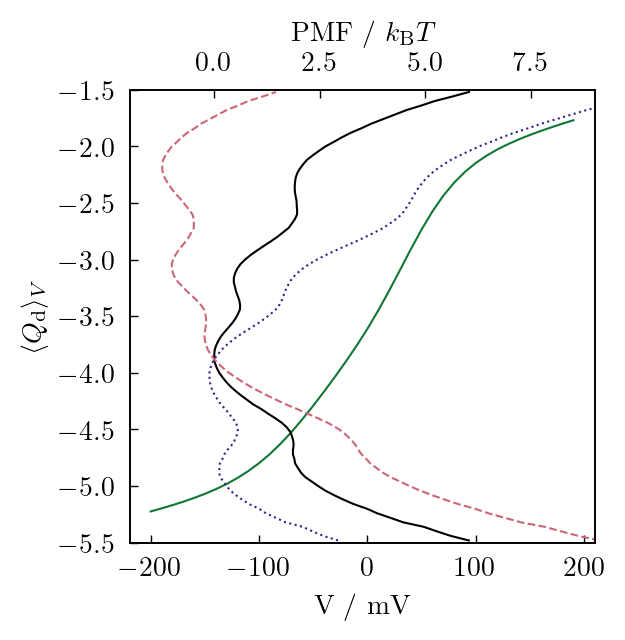

In [33]:
plt.figure(dpi=200, figsize=(3, 3))
plt.plot(voltage_range, biased_avg_qd, color="C3")
plt.xlabel("V / mV")
plt.ylabel(r"$\langle Q_{\rm d} \rangle_V$")
ax1 = plt.twiny()
ax1.plot(pmf, qc, color="black", label="0 mV")
ax1.plot(pmf - bias1, qc, "--", color="C0", label=f"${voltage1}$ mV")
ax1.plot(pmf - bias2, qc, ":", color="C1", label=f"${voltage2}$ mV")
ax1.set_xlabel("PMF / $k_{\mathrm B}T$")
ax1.set_ylim([lo, hi])
ax1.set_xlim([-2, 9])

(-2.0, 9.0)

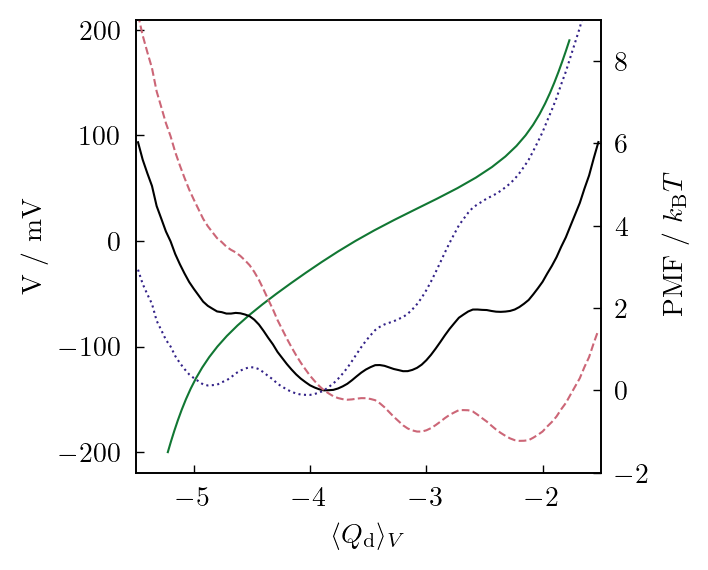

In [38]:
plt.figure(dpi=200, figsize=(3, 3))
# plt.grid(which='both')
plt.plot(biased_avg_qd, voltage_range, color="C3")
plt.ylabel("V / mV")
plt.xlabel(r"$\langle Q_{\rm d} \rangle_V$")
ax1 = plt.twinx()
ax1.plot(qc, pmf, color="black", label="0 mV")
ax1.plot(qc, pmf - bias1, "--", color="C0", label=f"${voltage1}$ mV")
ax1.plot(qc, pmf - bias2, ":", color="C1", label=f"${voltage2}$ mV")
ax1.set_ylabel("PMF / $k_{\mathrm B}T$")
ax1.set_xlim([lo, hi])
ax1.set_ylim([-2, 9])

In [56]:
voltage_range[23]

30

In [55]:
biased_avg_qd[23]

-3.092090476178654

# Correlation function

In [14]:
def biexp_model(params, t, y):
    return params[0] * np.exp(params[1] * t) + params[2] * np.exp(params[3] * t) - y

def biexp_fun(params, t):
    return params[0] * np.exp(params[1] * t) + params[2] * np.exp(params[3] * t)

In [16]:
x0 = (1.0, -1.0, 1.0, -1.0)
maxlag = 5000
t = np.arange(maxlag) * 0.1 # in ns
res_biexp = []
for i in range(4):
    res_biexp.append(scipy.optimize.least_squares(biexp_model, x0, args=(t[1:], acf[1:, i])))

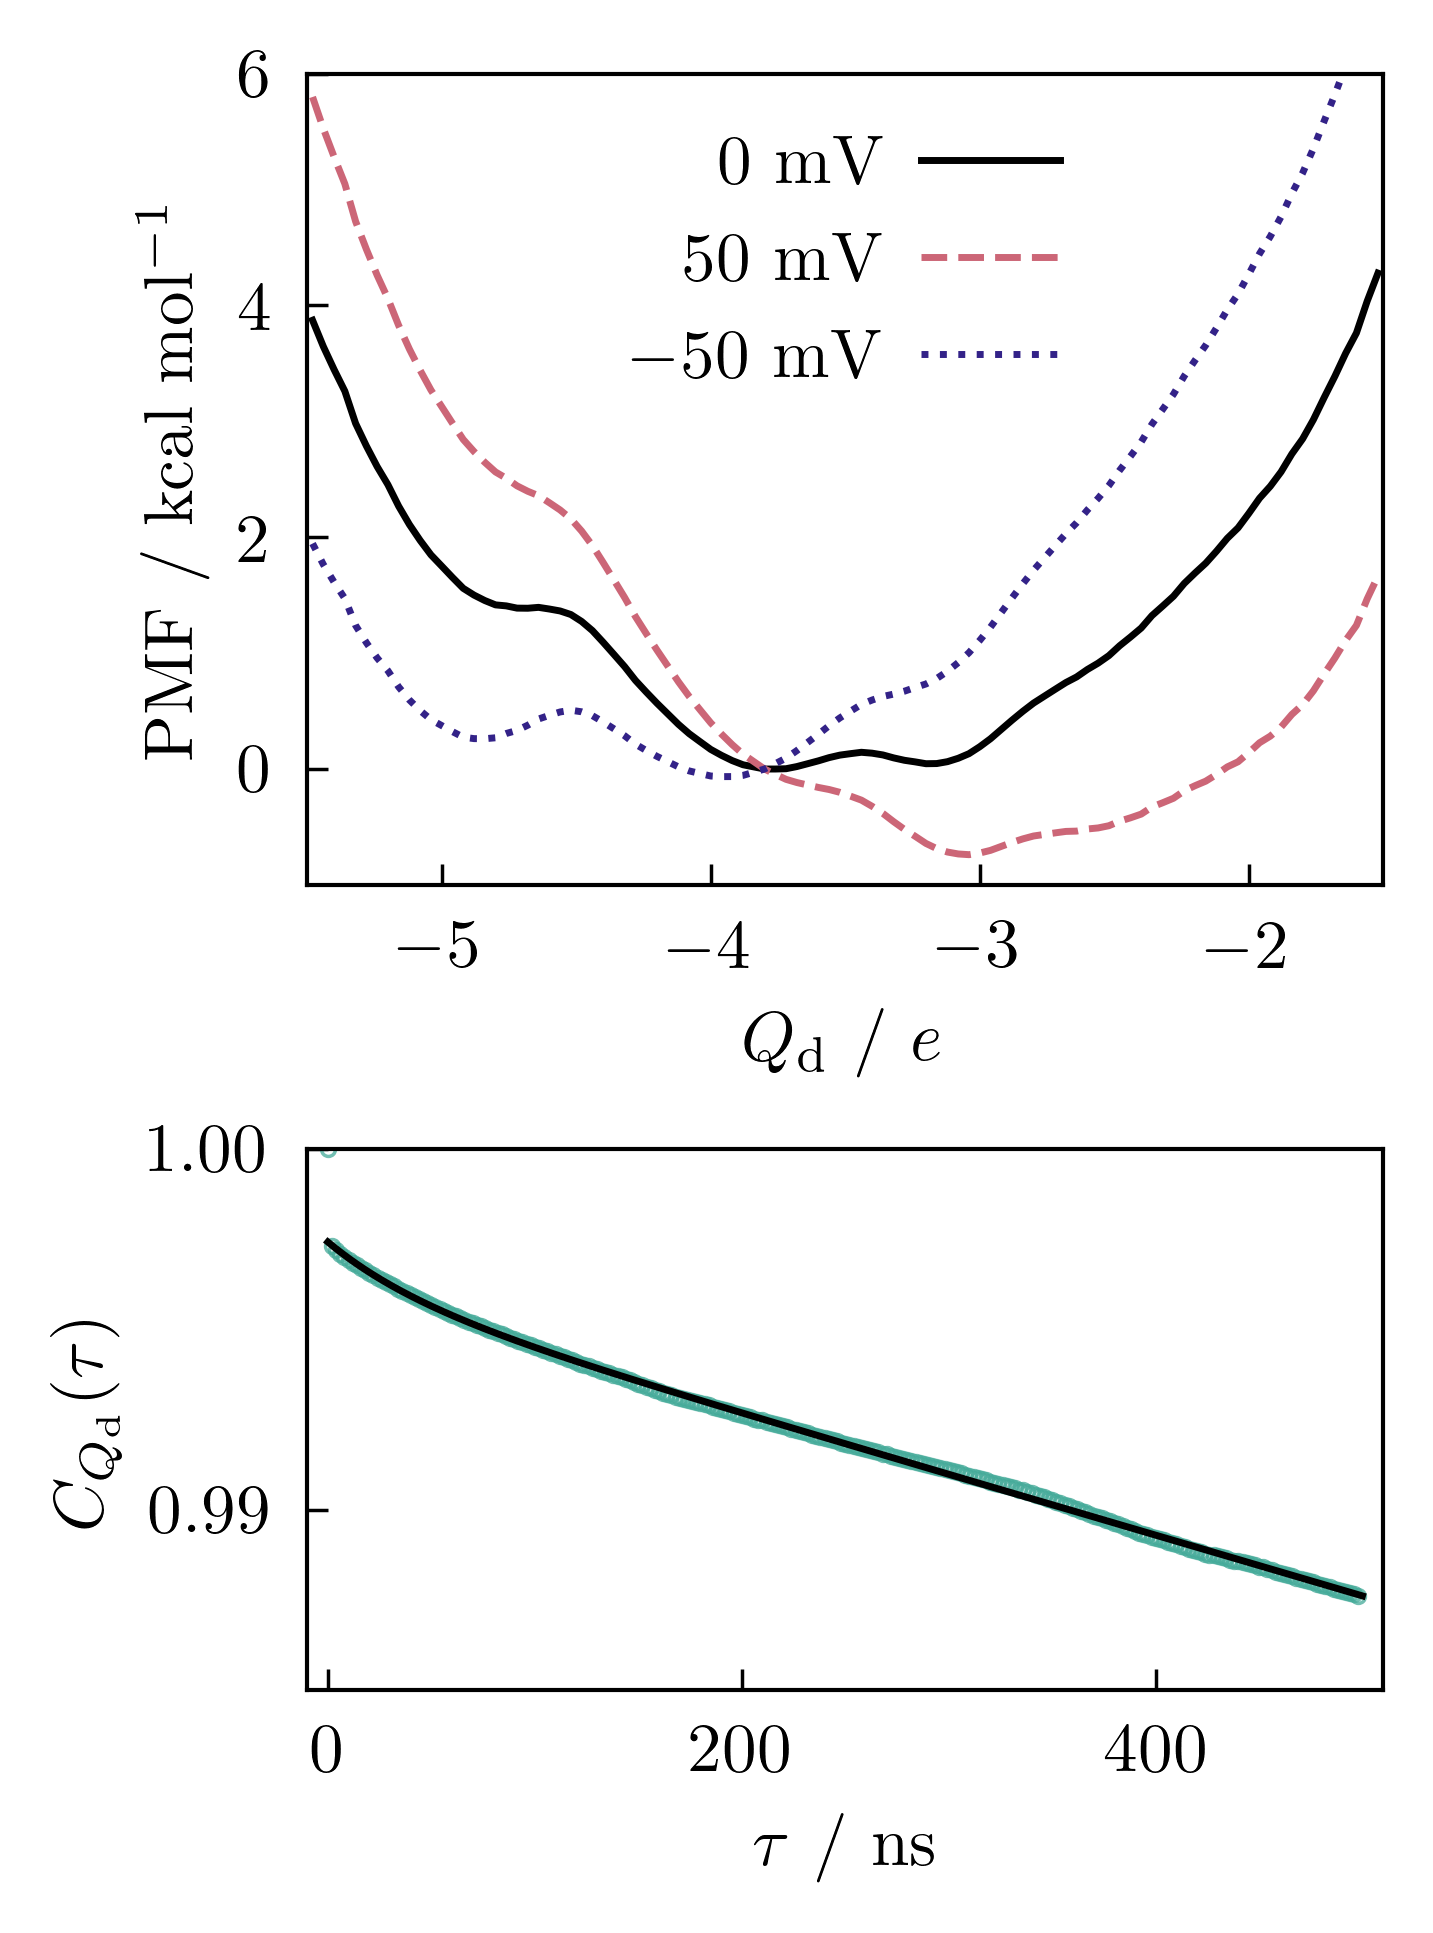

In [41]:
# PMF along Q_d with differing voltage biases
fig = plt.figure(figsize=(2.75, 3.75), dpi=500, constrained_layout=True)
gs = fig.add_gridspec(
    2,
    1,
    height_ratios=(3, 2),
    left=0.1,
    right=0.9,
    bottom=0.1,
    top=0.9,
    hspace=0.05,
)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

lo, hi = -5.5, -1.5
qe = np.linspace(lo, hi, 101)
qc = (qe[1:] + qe[:-1]) / 2

lag = 500

w_delay = [w[:-lag] for w in weights]
dq_delay = [dq[lag:] for dq in dq_trajs]
dens = extq.projection.density1d(dq_delay, w_delay, qe)
min_e = np.min(-np.log(dens[np.nonzero(dens)]))
pmf = -np.log(dens) - min_e

voltage1, voltage2, voltage3 = 50, -50, 20  # mV
offset = qc[np.argmin(pmf)]
bias1 = (qc - offset) * voltage1 * 0.03868  # convert to kT @ 300K
bias2 = (qc - offset) * voltage2 * 0.03868
bias3 = (qc - offset) * voltage3 * 0.03868

with mpl.rc_context({"lines.linewidth": 1.0}):
    ax0.plot(qc, pmf * 0.593, color="black", label="0 mV")
    ax0.plot(qc, (pmf - bias1) * 0.593, "--", color="C0", label=f"${voltage1}$ mV")
    ax0.plot(qc, (pmf - bias2) * 0.593, ":", color="C1", label=f"${voltage2}$ mV")
    # ax1.plot(qc, pmf - bias3, "-.", color="C3", label=f"${voltage3}$ mV")

# ax1.set_ylabel("PMF / $k_{\mathrm B}T$")
ax0.set_ylabel("PMF / kcal mol$^{-1}$")
ax0.set_xlabel("$Q_{\\rm d}$ / $e$")
ax0.set_xlim([lo, hi])
ax0.set_ylim([-1, 6])
pplt.legend(
    axs=ax0,
    ax=ax0,
    ncol=1,
    markerfirst=False,
    columnspacing=0.5,
    handletextpad=0.5,
    loc="upper center"
)

i = 1
res_lsq = res_biexp[i]
ax1.plot(t[::20], acf[::20, i], 'o', mfc='none', alpha=0.75, color="C6", mew=0.5)
ax1.plot(t, biexp_fun(res_lsq.x, t), color="black", lw=1.0)
ax1.set_xlabel(r"$\tau$ / ns")
# ax1.set_ylabel(r"$\langle Q_{\mathrm{d}}(0) Q_{\mathrm{d}}(\tau) \rangle / \langle Q_{\mathrm{d}}(0) Q_{\mathrm{d}}(0) \rangle$")
ax1.set_ylabel(r"$C_{Q_{\mathrm{d}}}(\tau)$")
ax1.set_xlim([-10, 510])
ax1.set_ylim([0.985, 1.0])

plt.savefig("../../fig/paper/dq_pmf_bias_corr.pdf", bbox_inches="tight")

In [42]:
print(f"A1 = {res_lsq.x[0]:.3f}, tau1 = {- 1e-3 / res_lsq.x[1]:.2f}, A2 = {res_lsq.x[2]:.3f}, tau2 = {- 1e-3 / res_lsq.x[3]:.2f}")

A1 = 0.996, tau1 = 58.65, A2 = 0.001, tau2 = 0.04


# Diffusion

In [11]:
def compute_D(trajs, dtrajs, nbins, lag):
    displacements = np.empty(nbins, dtype=object)
    for i in range(nbins):
        displacements[i] = []
    for traj, dtraj in zip(trajs, dtrajs):
        delta = traj[lag:] - traj[:-lag]
        for i, binnum in enumerate(dtraj[:-lag]):
            displacements[binnum].append(delta[i])
    diffusions = np.zeros(nbins)
    for i, deltalist in enumerate(displacements):
        diffusions[i] = np.var(deltalist) / (2 * lag)
    return diffusions

In [12]:
lags = [50, 100, 200, 500, 1000]
bins = np.arange(-5.5, -1.5, 0.1)
dtrajs = [np.digitize(traj, bins) for traj in dq_trajs]
Ds = []
for lag in lags:
    Ds.append(compute_D(dq_trajs, dtrajs, 41, lag))

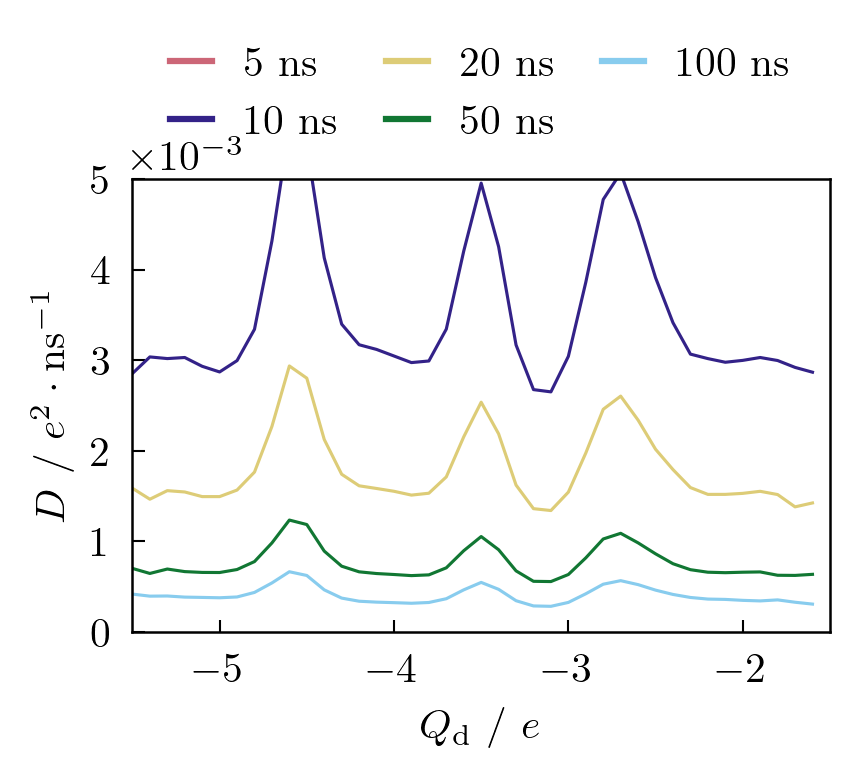

In [15]:
f = plt.figure(figsize=(3, 2), dpi=300)
for lag, D in zip(lags, Ds):
    plt.plot(np.arange(-5.6, -1.5, 0.1), D * 10, label=f"{lag * 0.1:.0f} ns")
plt.xlabel("$Q_{\\rm d}$ / $e$")
plt.ylabel("$D$ / $e^2 \cdot\\rm{ns}^{-1}$")
plt.xlim([-5.5, -1.5])
plt.ylim([0, 0.005])
leg = pplt.legend(outside="top", ncol=3, handlelength=1)
for legobj in leg.legendHandles:
    legobj.set_linewidth(1.5)
# plt.savefig("../../fig/paper/dq_diffusion.pdf", bbox_inches='tight')

In [16]:
for lag, D in zip(lags, Ds):
    print(lag, np.mean(D) * 10)

50 0.006776918289954205
100 0.003481261715906574
200 0.0017914117914862898
500 0.0007597568231590967
1000 0.0004092513563627627


# 